# **Impl√©mentation du mod√®le**
---

## Sommaire

* [Introduction](#partie1)
* [Formatage des donn√©es](#partie2)
* [D√©termination des chocs](#partie3)
    * [Essai 1: avec 4 lags](#partie31)
    * [Essai 2: avec 2 lags](#partie32)
    * [Essai 3: avec 1 lag](#partie33)
    * [Essai 4: avec 2 lags sans les corporate spreads](#partie34)
    * [Essai 5: avec 2 lags sans l'inflation](#partie35)
* [Impact des chocs mon√©taires](#partie4)
    * [Effet sur le PIB am√©ricain](#partie41)
    * [Effet sur le PIB des pays europ√©ens](#partie42)
    * [Effet sur l'inflation des pays europ√©ens](#partie43)
    * [Effet sur le les taux directeurs europ√©ens](#partie44)
* [Utilisation de la stationnarit√© et de la croissance du PIB](#partie5)
    * [Test de stationnarit√© du choc](#partie51)
    * [Effet sur la croissance du PIB des US](#partie52)
    * [Effet sur la croissance du PIB des pays europ√©ens](#partie53)













## Introduction <a class="anchor" id="partie1"></a>

Contrairement au notebook "mod√®le", ici nous nous int√©ressons aux chocs de la politique mon√©taire am√©ricaine sur les pays europ√©ens.



Ce notebook contient les codes n√©cessaire √† la mise en place du mod√®le. Le mod√®le est inspir√© de celui de Iacoviello et Navarro : 

- La premi√®re √©tape consiste √† identifier les chocs de politique mon√©taire, en prenant le r√©sidu de la r√©gression du taux d'int√©r√™t sur l'√©cart d'inflation par rapport √† la cible et l'output gap ou le ch√¥mage. En r√©alit√© Iacoviello et Navarro utilisent des lags et valeurs pr√©sentes de l'inflation, des spreads de cr√©dit, du PIB et des lags des taux des fonds f√©d√©raux.
Il nous manque donc l'output gap, l'inflation et le ch√¥mage de la zone euro
- La deuxi√®me √©tape consiste √† estimer l'impact de ces chocs sur l'activit√© √©conomique (PIB, emploi ...) en r√©gressant ces variables sur les chocs et des variables de contr√¥les (4 lags du PIB et des trends lin√©aires et quadratiques)

## Formatage des donn√©es <a class="anchor" id="partie2"></a>

In [259]:
# import des donn√©es am√©ricaines

!pip install openpyxl 
import pandas as pd

sheets_to_load = ["Daily, Close", "Monthly", "Quarterly"]  # Noms des feuilles √† importer
dfs = pd.read_excel("../Donn√©es_extraites/data_US.xlsx", sheet_name=sheets_to_load, header=0)
# Acc√©der aux DataFrames import√©s
dfD = dfs["Daily, Close"]
dfM = dfs["Monthly"]
dfQ = dfs["Quarterly"]

# renommer les variables
dfD.columns = dfD.iloc[0] 
dfD = dfD[1:].reset_index(drop=True)

dfM.columns = dfM.iloc[0] 
dfM = dfM[1:].reset_index(drop=True)


# Il faut trimestrialiser les donn√©es (on prend la moyenne)

dfM["date"] = pd.to_datetime(dfM["date"])  # Convertir en datetime
dfM = dfM.set_index("date")  # D√©finir la colonne "date" comme index
dfM_Q = dfM.resample("Q").mean()  # Appliquer le resample par trimestre

dfD["date"] = pd.to_datetime(dfD["date"])  # Convertir en datetime
dfD = dfD.set_index("date")  # D√©finir la colonne "date" comme index
dfD_Q = dfD.resample("Q").mean()  # Appliquer le resample par trimestre

# harmoniser les dates
dfD_Q.index = dfD_Q.index.to_period("Q")  
dfM_Q.index = dfM_Q.index.to_period("Q")

dfQ=dfQ.rename(columns={"observation_date":"date"})
dfQ = dfQ.set_index("date")
dfQ.index = dfQ.index.to_period("Q")



/tmp/ipykernel_19990/4245104104.py:25: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  dfM_Q = dfM.resample("Q").mean()  # Appliquer le resample par trimestre
/tmp/ipykernel_19990/4245104104.py:29: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  dfD_Q = dfD.resample("Q").mean()  # Appliquer le resample par trimestre


In [ ]:
import numpy as np
data_US = dfM_Q.merge(dfD_Q, on='date').merge(dfQ, on='date')

# Cr√©er la variable d'inflation (sur 4 trimestres)
data_US["inflation"] = data_US["CPI"].pct_change(periods=4) * 100  # pct_change() donne la variation en pourcentage



# Cr√©er une variable de temps et tendnce quadratique
data_US['time'] = range(1, len(data_US) + 1)
data_US['time_squared'] = data_US['time'] ** 2

# Cr√©er 4 lags pour chaque variable
for col in data_US.columns:
    for lag in range(1, 5):  # Cr√©er les lags 1, 2, 3, 4
        data_US[f"{col}_lag{lag}"] = data_US[col].shift(lag)


# Filtrer les colonnes contenant 'GDP'
gdp_columns = [col for col in data_US.columns if 'GDP' in col]

# Cr√©er de nouvelles colonnes en log pour chaque colonne contenant 'GDP'
for col in gdp_columns:
    data_US[f"{col}_log"] = np.log(data_US[col])



/tmp/ipykernel_19990/1216911491.py:5: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data_US["inflation"] = data_US["CPI"].pct_change(periods=4) * 100  # pct_change() donne la variation en pourcentage


In [261]:
data_US

CPI Policy rate Industrial production activit√© mensualis√©e  \
date                                                                        
1996Q4  158.666667        5.28             76.830067            99.577753   
1997Q1  159.633333    5.276667             78.286233            99.592907   
1997Q2       160.0    5.523333             79.403833            99.823247   
1997Q3       160.8    5.533333               81.2606           100.017223   
1997Q4  161.666667    5.506667             83.325533             100.0244   
...            ...         ...                   ...                  ...   
2023Q4  308.158333        5.33              102.6986            100.44725   
2024Q1  310.974333        5.33            102.242767                  NaN   
2024Q2  313.095667        5.33              102.8633                  NaN   
2024Q3  314.182667    5.263333              102.7114                  NaN   
2024Q4  316.538667        4.65            102.485133                  NaN   

       spread corporate      GDPC1  inflation  time  time_squared    CPI_lag1  \
date                                                                            
1996Q4              0.6  12037.775        NaN     1             1        None   
1997Q1         0.591475  12115.472        NaN     2             4  158.666667   
1997Q2         0.584615  12317.221        NaN     3             9  159.633333   
1997Q3         0.568308  12471.010        NaN     4            16       160.0   
1997Q4         0.667273  12577.495   1.890756     5            25       160.8   
...                 ...        ...        ...   ...           ...         ...   
2023Q4         1.194923  22960.600   3.236199   109         11881  306.042333   
2024Q1         0.987969  23053.545   3.247987   110         12100  308.158333   
2024Q2         0.914394  23223.906   3.187395   111         12321  310.974333   
2024Q3         0.966866  23400.294   2.659872   112         12544  313.095667   
2024Q4         0.822923  23536.293   2.719489   113         12769  314.182667   

          CPI_lag2    CPI_lag3    CPI_lag4 Policy rate_lag1 Policy rate_lag2  \
date                                                                           
1996Q4        None        None        None             None             None   
1997Q1        None        None        None             5.28             None   
1997Q2  158.666667        None        None         5.276667             5.28   
1997Q3  159.633333  158.666667        None         5.523333         5.276667   
1997Q4       160.0  159.633333  158.666667         5.533333         5.523333   
...            ...         ...         ...              ...              ...   
2023Q4  303.424333  301.191667  298.498333             5.26             4.99   
2024Q1  306.042333  303.424333  301.191667             5.33             5.26   
2024Q2  308.158333  306.042333  303.424333             5.33             5.33   
2024Q3  310.974333  308.158333  306.042333             5.33             5.33   
2024Q4  313.095667  310.974333  308.158333         5.263333             5.33   

       Policy rate_lag3 Policy rate_lag4 Industrial production_lag1  \
date                                                                  
1996Q4             None             None                       None   
1997Q1             None             None                  76.830067   
1997Q2             None             None                  78.286233   
1997Q3             5.28             None                  79.403833   
1997Q4         5.276667             5.28                    81.2606   
...                 ...              ...                        ...   
2023Q4         4.516667         3.653333                 103.158467   
2024Q1             4.99         4.516667                   102.6986   
2024Q2             5.26             4.99                 102.242767   
2024Q3             5.33             5.26                   102.8633   
2024Q4             5.33             5.33                   102.7

## D√©termination des chocs <a class="anchor" id="partie3"></a>

In [262]:
data_US.columns

Index(['CPI', 'Policy rate', 'Industrial production', 'activit√© mensualis√©e',
       'spread corporate', 'GDPC1', 'inflation', 'time', 'time_squared',
       'CPI_lag1', 'CPI_lag2', 'CPI_lag3', 'CPI_lag4', 'Policy rate_lag1',
       'Policy rate_lag2', 'Policy rate_lag3', 'Policy rate_lag4',
       'Industrial production_lag1', 'Industrial production_lag2',
       'Industrial production_lag3', 'Industrial production_lag4',
       'activit√© mensualis√©e_lag1', 'activit√© mensualis√©e_lag2',
       'activit√© mensualis√©e_lag3', 'activit√© mensualis√©e_lag4',
       'spread corporate_lag1', 'spread corporate_lag2',
       'spread corporate_lag3', 'spread corporate_lag4', 'GDPC1_lag1',
       'GDPC1_lag2', 'GDPC1_lag3', 'GDPC1_lag4', 'inflation_lag1',
       'inflation_lag2', 'inflation_lag3', 'inflation_lag4', 'time_lag1',
       'time_lag2', 'time_lag3', 'time_lag4', 'time_squared_lag1',
       'time_squared_lag2', 'time_squared_lag3', 'time_squared_lag4',
       'GDPC1_log', 'GDPC1_

In [263]:
data_US_clean = data_US.dropna()

In [264]:
data_US_clean.loc["2006-01-01" : "2012-01-01"]


CPI Policy rate Industrial production activit√© mensualis√©e  \
date                                                                        
2006Q1  199.466667    4.456667                98.229              101.124   
2006Q2  201.266667    4.906667             98.809933           101.162233   
2006Q3  203.166667    5.246667             99.201467             101.1091   
2006Q4  202.333333    5.246667               99.4439           101.193567   
2007Q1     204.317    5.256667            100.455467           101.324367   
2007Q2     206.631        5.25            101.617967             101.5208   
2007Q3     207.939    5.073333              101.7108           101.753433   
2007Q4  210.489667    4.496667              102.0459             101.8628   
2008Q1  212.769667    3.176667              101.7919             101.7889   
2008Q2  215.537667    2.086667            100.253933           101.587233   
2008Q3     218.861        1.94             96.942033           100.778533   
2008Q4  213.848667    0.506667               92.7956            99.361927   
2009Q1  212.377667    0.183333             87.561033            98.199183   
2009Q2     213.507        0.18             85.136167            97.750203   
2009Q3     215.344    0.156667               86.5689             97.90173   
2009Q4      217.03        0.12             87.920033            98.354743   
2010Q1     217.374    0.133333             89.609967            98.818063   
2010Q2  217.297333    0.193333             91.355133            99.284133   
2010Q3  217.934333    0.186667             92.567267            99.641103   
2010Q4     219.699    0.186667               92.9545            99.715867   
2011Q1  222.043667    0.156667             93.453933            99.569483   
2011Q2  224.568333    0.093333             93.826233            99.478357   
2011Q3  226.032667    0.083333             94.872533            99.521963   
2011Q4  227.047333    0.073333             95.849267             99.81601   
2012Q1     228.326    0.103333             96.795533              100.101   

       spread corporate      GDPC1  inflation  time  time_squared    CPI_lag1  \
date                                                                            
2006Q1         0.894063  16353.835   3.690868    38          1444  198.433333   
2006Q2         0.909538  16396.151   3.924269    39          1521  199.466667   
2006Q3          0.97197  16420.738   3.340115    40          1600  201.266667   
2006Q4         0.935846  16561.866   1.965396    41          1681  203.166667   
2007Q1         0.897077  16611.690   2.431651    42          1764  202.333333   
2007Q2         0.942969  16713.314   2.665287    43          1849     204.317   
2007Q3         1.328485  16809.587   2.348975    44          1936     206.631   
2007Q4         1.741231  16915.191   4.031137    45          2025     207.939   
2008Q1         2.482222  16843.003   4.137035    46          2116  210.489667   
2008Q2         2.615606  16943.291   4.310421    47          2209  212.769667   
2008Q3         3.258657  16854.295   5.252502    48          2304  215.537667   
2008Q4         6.043333  16485.350   1.595803    49          2401     218.861   
2009Q1         5.617692  16298.262  -0.184237    50          2500  213.848667   
2009Q2         4.389846  16269.145  -0.942140    51          2601  212.377667   
2009Q3         2.710909  16326.281  -1.606956    52          2704     213.507   
2009Q4         2.162879  16502.754   1.487656    53          2809     215.344   
2010Q1         1.795231  16582.710   2.352570    54          2916      217.03   
2010Q2         1.830937  16743.162   1.775274    55          3025     217.374   
2010Q3         1.913134  16872.266   1.202882    56          3136  217.297333   
2010Q4         1.759552  16960.864   1.229784    57          3249  217.934333   
2011Q1         1.549844  16920.632   2.148218    58          3364     219.699   
2011Q2         1.538154  17035.114   3.346106    59          3481  222

### 1er essai : mod√®le avec 4 lags <a class="anchor" id="partie31"></a>

In [265]:
import statsmodels.api as sm
from statsmodels.iolib.summary2 import summary_col

# Supprimer les lignes avec NaN ou Inf
data_US_clean=data_US_clean.apply(pd.to_numeric, errors='coerce')
# D√©finition de Y (variable d√©pendante)
Y = data_US_clean['Policy rate']

# S√©lectionner toutes les colonnes sauf 'key_rate' et 'TIME_PERIOD'
X = data_US_clean[['Policy rate_lag1','Policy rate_lag2', 'Policy rate_lag3', 'Policy rate_lag4',
'inflation','inflation_lag1','inflation_lag2', 'inflation_lag3', 'inflation_lag4',
'GDPC1_log', 'GDPC1_lag1_log', 'GDPC1_lag2_log', 'GDPC1_lag3_log','GDPC1_lag4_log',
'spread corporate','spread corporate_lag1', 'spread corporate_lag2','spread corporate_lag3', 'spread corporate_lag4',
'time_squared']]



# Ajouter une constante pour l'intercept dans la r√©gression
X = sm.add_constant(X)

# R√©gression
model = sm.OLS(Y, X).fit()

# Extraire les r√©sidus comme chocs mon√©taires
data_US_clean['monetary_shocks_4lags'] = model.resid

# Afficher le r√©sum√© de la r√©gression
print(model.summary())


with open("regression_results4 US.tex", "w") as f:
    f.write(model.summary().as_latex())

    
# Sauvegarder les r√©sultats dans un fichier CSV
data_US_clean[['time', 'monetary_shocks_4lags']].to_csv('identified_monetary_shocks.csv', index=False)

# Exporter les r√©sultats de la r√©gression en latex
with open("regression_results_US.tex", "w") as f:
    f.write(model.summary().as_latex())


                            OLS Regression Results                            
Dep. Variable:            Policy rate   R-squared:                       0.986
Model:                            OLS   Adj. R-squared:                  0.982
Method:                 Least Squares   F-statistic:                     280.2
Date:                Thu, 08 May 2025   Prob (F-statistic):           1.58e-65
Time:                        16:30:23   Log-Likelihood:                 1.2524
No. Observations:                 101   AIC:                             39.50
Df Residuals:                      80   BIC:                             94.41
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     0.18

In [266]:
import statsmodels.api as sm
import pandas as pd
from statsmodels.iolib.summary2 import summary_col

# Supprimer les lignes avec NaN ou Inf
data_US_clean = data_US_clean.apply(pd.to_numeric, errors='coerce')

# D√©finition de Y (variable d√©pendante)
Y = data_US_clean['Policy rate']

# S√©lectionner toutes les colonnes explicatives
X = data_US_clean[['Policy rate_lag1', 'Policy rate_lag2', 'Policy rate_lag3', 'Policy rate_lag4',
                   'inflation', 'inflation_lag1', 'inflation_lag2', 'inflation_lag3', 'inflation_lag4',
                   'GDPC1_log', 'GDPC1_lag1_log', 'GDPC1_lag2_log', 'GDPC1_lag3_log', 'GDPC1_lag4_log',
                   'spread corporate', 'spread corporate_lag1', 'spread corporate_lag2', 
                   'spread corporate_lag3', 'spread corporate_lag4', 'time_squared']]

# Ajouter une constante
X = sm.add_constant(X)

# R√©gression
model = sm.OLS(Y, X).fit()
model_1=model
# Extraire les r√©sidus comme chocs mon√©taires
data_US_clean['monetary_shocks_4lags'] = model.resid

# Fonction pour ajouter les √©toiles de significativit√©
def significance_stars(pval):
    if pval < 0.01:
        return '***'
    elif pval < 0.05:
        return '**'
    elif pval < 0.1:
        return '*'
    else:
        return ''

# Appliquer la fonction avant de formater les nombres
p_values = model.pvalues.apply(significance_stars)

# Cr√©er un DataFrame des r√©sultats
results_df = pd.DataFrame({
    'Coefficient': model.params.map('{:.4f}'.format) + p_values,
    'Std. Error': model.bse.map('{:.4f}'.format),
    't-Statistic': model.tvalues.map('{:.4f}'.format),
    'P-Value': model.pvalues.map('{:.4f}'.format),
})

# Reformater les r√©sultats pour summary_col
model_summary = summary_col([model], stars=True, float_format="%.4f",
                            model_names=["R√©gression"],
                            info_dict={'R-squared': lambda x: f"{x.rsquared:.4f}",
                                       'Adj. R-squared': lambda x: f"{x.rsquared_adj:.4f}",
                                       'F-statistic': lambda x: f"{x.fvalue:.2f} (p={x.f_pvalue:.4g})"})

# Exporter le tableau en LaTeX
latex_table = model_summary.as_latex()

with open("regression_results_full_US.tex", "w") as f:
    f.write(latex_table)

# Affichage du tableau final
print(model_summary)

# Enregistrer les R carr√© ajst√©, AIC et BIC pour comparer les mod√®les ensuite
R_1 = model.rsquared
R_adj_1 = model.rsquared_adj
aic_1 = model.aic
bic_1 = model.bic



                           R√©gression    
-----------------------------------------
const                 0.1814             
                      (8.7748)           
Policy rate_lag1      1.6687***          
                      (0.1167)           
Policy rate_lag2      -0.7024***         
                      (0.2355)           
Policy rate_lag3      -0.1986            
                      (0.2396)           
Policy rate_lag4      0.1693             
                      (0.1263)           
inflation             0.0569             
                      (0.0436)           
inflation_lag1        -0.0207            
                      (0.0643)           
inflation_lag2        0.0168             
                      (0.0640)           
inflation_lag3        0.0110             
                      (0.0639)           
inflation_lag4        0.0210             
                      (0.0453)           
GDPC1_log             5.9692**           
                      (2.7764)  

### 2√®me essai: mod√®le avec 2 lags <a class="anchor" id="partie32"></a>

In [267]:
import pandas as pd
import statsmodels.api as sm

# Supprimer les lignes avec NaN ou Inf
data_US_clean = data_US_clean.apply(pd.to_numeric, errors='coerce')

# D√©finition de Y (variable d√©pendante)
Y = data_US_clean['Policy rate']

# S√©lectionner toutes les colonnes explicatives
X = data_US_clean[['Policy rate_lag1','Policy rate_lag2',
                   'inflation','inflation_lag1','inflation_lag2', 
                   'GDPC1_log', 'GDPC1_lag1_log', 'GDPC1_lag2_log', 
                   'spread corporate','spread corporate_lag1', 'spread corporate_lag2',
                   'time_squared']]

# Ajouter une constante
X = sm.add_constant(X)

# R√©gression
model = sm.OLS(Y, X).fit()
model_2=model

# Extraire les r√©sidus comme chocs mon√©taires
data_US_clean['monetary_shocks'] = model.resid

# Ajouter les √©toiles de significativit√©
def significance_stars(p):
    if p < 0.01:
        return '***'
    elif p < 0.05:
        return '**'
    elif p < 0.10:
        return '*'
    else:
        return ''

# Construire un DataFrame avec les r√©sultats format√©s
coef_table = pd.DataFrame({
    "Coefficient": model.params,
    "Std. Error": model.bse,
    "t-Statistic": model.tvalues,
    "P-Value": model.pvalues
})

# Ajouter les √©toiles aux coefficients
coef_table["Significance"] = coef_table["P-Value"].apply(significance_stars)
coef_table["Coefficient"] = coef_table["Coefficient"].round(4).astype(str) + coef_table["Significance"]

# R√©organiser les colonnes pour l'affichage
coef_table = coef_table[["Coefficient", "Std. Error", "t-Statistic", "P-Value"]]

# Renommer les colonnes en ajoutant le format LaTeX pour du texte en gras
coef_table.columns = [r"\textbf{Coefficient}", r"\textbf{Std. Error}", r"\textbf{t-Statistic}", r"\textbf{P-Value}"]

# Ajouter les statistiques globales en haut de la table
stats_dict = {
    r"\textbf{R-squared}": round(model.rsquared, 4),
    r"\textbf{Adj. R-squared}": round(model.rsquared_adj, 4),
    r"\textbf{F-statistic}": round(model.fvalue, 4),
    r"\textbf{Prob (F-statistic)}": round(model.f_pvalue, 4),
    r"\textbf{Observations}": int(model.nobs)
}

# Convertir en DataFrame et transposer pour affichage
stats_table = pd.DataFrame.from_dict(stats_dict, orient='index', columns=["Value"]).T

# Convertir en LaTeX avec statistiques au d√©but
latex_table = stats_table.to_latex(index=False, escape=False) + "\n" + coef_table.to_latex(index=True, escape=False)

# Sauvegarder en fichier .tex
with open("regression_results_2_lags.tex", "w") as f:
    f.write(latex_table)

# Afficher le r√©sum√© de la r√©gression
print(model.summary())

# Enregistrer les R carr√© ajst√©, AIC et BIC pour comparer les mod√®les ensuite
R_2 = model.rsquared
R_adj_2 = model.rsquared_adj
aic_2 = model.aic
bic_2 = model.bic


                            OLS Regression Results                            
Dep. Variable:            Policy rate   R-squared:                       0.985
Model:                            OLS   Adj. R-squared:                  0.983
Method:                 Least Squares   F-statistic:                     480.0
Date:                Thu, 08 May 2025   Prob (F-statistic):           1.14e-74
Time:                        16:30:25   Log-Likelihood:                -2.1134
No. Observations:                 101   AIC:                             30.23
Df Residuals:                      88   BIC:                             64.22
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     3.61

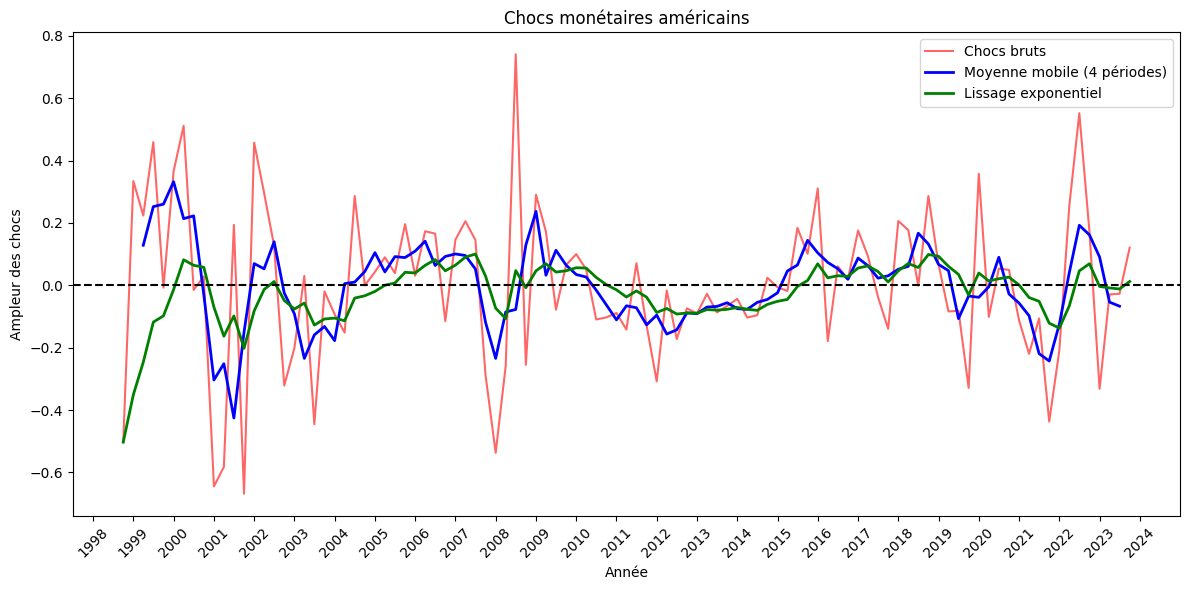

In [268]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

data_US_clean.index = data_US_clean.index.to_timestamp()


# Appliquer une moyenne glissante sur 6 p√©riodes (ajuster selon les besoins)
data_US_clean['monetary_shocks_smooth'] = data_US_clean['monetary_shocks'].rolling(window=4, center=True).mean()
data_US_clean['monetary_shocks_ewma'] = data_US_clean['monetary_shocks'].ewm(span=10, adjust=False).mean()

# Tracer les s√©ries
plt.figure(figsize=(12, 6))
plt.plot(data_US_clean.index, data_US_clean['monetary_shocks'], color='red', alpha=0.6, label='Chocs bruts')
plt.plot(data_US_clean.index, data_US_clean['monetary_shocks_smooth'], color='blue', linewidth=2, label='Moyenne mobile (4 p√©riodes)')
plt.plot(data_US_clean.index, data_US_clean['monetary_shocks_ewma'], color='green', linewidth=2, label='Lissage exponentiel')
plt.axhline(0, linestyle="--", color="black")
plt.xlabel('Ann√©e')
plt.ylabel('Ampleur des chocs')
plt.title('Chocs mon√©taires am√©ricains')
plt.legend()

# üëâ Personnaliser l'axe des X pour afficher une ann√©e tous les ans
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.YearLocator(1))  # Ticks tous les ans
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  # Format affich√© : 2020, 2021, etc.
plt.xticks(rotation=45)

plt.tight_layout()
plt.savefig("monetary_shocks.png", dpi=300)
plt.show()

### 3√®me essai: avec 1 lag <a class="anchor" id="partie33"></a>

In [200]:
import pandas as pd
import statsmodels.api as sm

# Supprimer les lignes avec NaN ou Inf
data_US_clean = data_US_clean.apply(pd.to_numeric, errors='coerce')

# D√©finition de Y (variable d√©pendante)
Y = data_US_clean['Policy rate']

# S√©lectionner toutes les colonnes explicatives
X = data_US_clean[['Policy rate_lag1',
                   'inflation','inflation_lag1',
                   'GDPC1_log', 'GDPC1_lag1_log', 
                   'spread corporate','spread corporate_lag1', 
                   'time_squared']]

# Ajouter une constante
X = sm.add_constant(X)

# R√©gression
model = sm.OLS(Y, X).fit()
model_3=model

# Extraire les r√©sidus comme chocs mon√©taires
data_US_clean['monetary_shocks_1lag'] = model.resid

# Ajouter les √©toiles de significativit√©
def significance_stars(p):
    if p < 0.01:
        return '***'
    elif p < 0.05:
        return '**'
    elif p < 0.10:
        return '*'
    else:
        return ''

# Construire un DataFrame avec les r√©sultats format√©s
coef_table = pd.DataFrame({
    "Coefficient": model.params,
    "Std. Error": model.bse,
    "t-Statistic": model.tvalues,
    "P-Value": model.pvalues
})

# Ajouter les √©toiles aux coefficients
coef_table["Significance"] = coef_table["P-Value"].apply(significance_stars)
coef_table["Coefficient"] = coef_table["Coefficient"].round(4).astype(str) + coef_table["Significance"]

# R√©organiser les colonnes pour l'affichage
coef_table = coef_table[["Coefficient", "Std. Error", "t-Statistic", "P-Value"]]

# Renommer les colonnes en ajoutant le format LaTeX pour du texte en gras
coef_table.columns = [r"\textbf{Coefficient}", r"\textbf{Std. Error}", r"\textbf{t-Statistic}", r"\textbf{P-Value}"]

# Ajouter les statistiques globales en haut de la table
stats_dict = {
    r"\textbf{R-squared}": round(model.rsquared, 4),
    r"\textbf{Adj. R-squared}": round(model.rsquared_adj, 4),
    r"\textbf{F-statistic}": round(model.fvalue, 4),
    r"\textbf{Prob (F-statistic)}": round(model.f_pvalue, 4),
    r"\textbf{Observations}": int(model.nobs)
}

# Convertir en DataFrame et transposer pour affichage
stats_table = pd.DataFrame.from_dict(stats_dict, orient='index', columns=["Value"]).T

# Convertir en LaTeX avec statistiques au d√©but
latex_table = stats_table.to_latex(index=False, escape=False) + "\n" + coef_table.to_latex(index=True, escape=False)

# Sauvegarder en fichier .tex
with open("regression_results_1_lags.tex", "w") as f:
    f.write(latex_table)

# Afficher le r√©sum√© de la r√©gression
print(model.summary())

# Enregistrer les R carr√© ajst√©, AIC et BIC pour comparer les mod√®les ensuite
R_3 = model.rsquared
R_adj_3 = model.rsquared_adj
aic_3 = model.aic
bic_3 = model.bic

                            OLS Regression Results                            
Dep. Variable:            Policy rate   R-squared:                       0.972
Model:                            OLS   Adj. R-squared:                  0.969
Method:                 Least Squares   F-statistic:                     332.9
Date:                Thu, 08 May 2025   Prob (F-statistic):           1.92e-56
Time:                        16:02:12   Log-Likelihood:                -29.149
No. Observations:                  86   AIC:                             76.30
Df Residuals:                      77   BIC:                             98.39
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     2.07

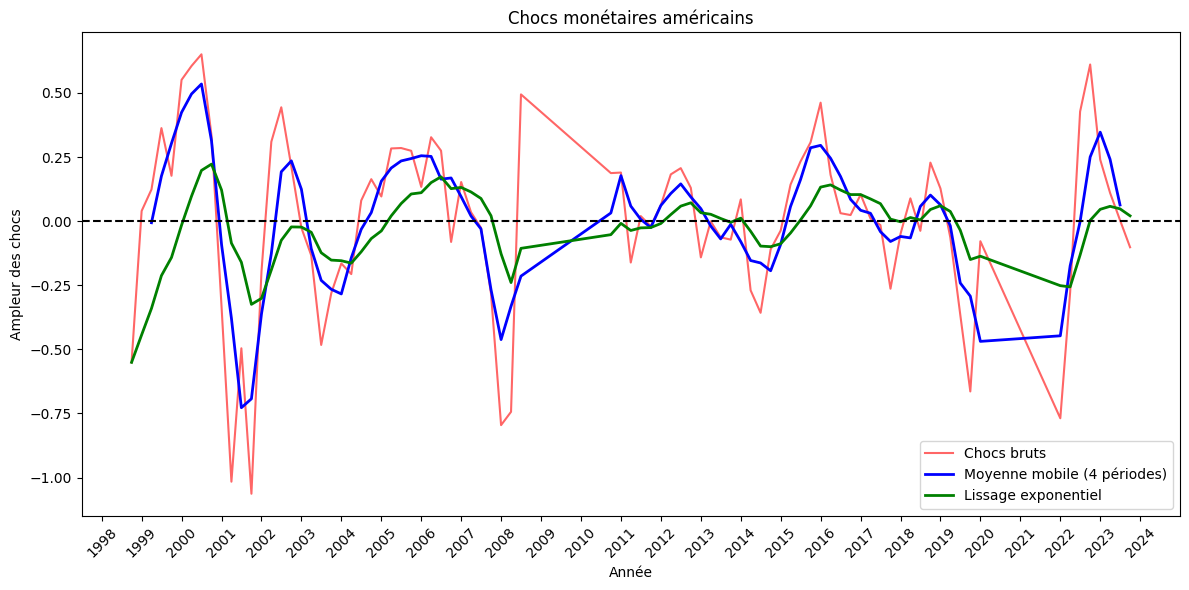

In [201]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

#data_US_clean.index = data_US_clean.index.to_timestamp()


# Appliquer une moyenne glissante sur 6 p√©riodes (ajuster selon les besoins)
data_US_clean['monetary_shocks_smooth'] = data_US_clean['monetary_shocks_1lag'].rolling(window=4, center=True).mean()
data_US_clean['monetary_shocks_ewma'] = data_US_clean['monetary_shocks_1lag'].ewm(span=10, adjust=False).mean()

# Tracer les s√©ries
plt.figure(figsize=(12, 6))
plt.plot(data_US_clean.index, data_US_clean['monetary_shocks_1lag'], color='red', alpha=0.6, label='Chocs bruts')
plt.plot(data_US_clean.index, data_US_clean['monetary_shocks_smooth'], color='blue', linewidth=2, label='Moyenne mobile (4 p√©riodes)')
plt.plot(data_US_clean.index, data_US_clean['monetary_shocks_ewma'], color='green', linewidth=2, label='Lissage exponentiel')
plt.axhline(0, linestyle="--", color="black")
plt.xlabel('Ann√©e')
plt.ylabel('Ampleur des chocs')
plt.title('Chocs mon√©taires am√©ricains')
plt.legend()

# üëâ Personnaliser l'axe des X pour afficher une ann√©e tous les ans
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.YearLocator(1))  # Ticks tous les ans
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  # Format affich√© : 2020, 2021, etc.
plt.xticks(rotation=45)

plt.tight_layout()
plt.savefig("monetary_shocks_1lag.png", dpi=300)
plt.show()

### 4√® essai: mod√®le sans les corporate spreads, avec 2 lags <a class="anchor" id="partie34"></a>

In [202]:
import pandas as pd
import statsmodels.api as sm

# Supprimer les lignes avec NaN ou Inf
data_US_clean = data_US_clean.apply(pd.to_numeric, errors='coerce')

# D√©finition de Y (variable d√©pendante)
Y = data_US_clean['Policy rate']

# S√©lectionner toutes les colonnes explicatives
X = data_US_clean[['Policy rate_lag1','Policy rate_lag2',
                   'inflation','inflation_lag1','inflation_lag2', 
                   'GDPC1_log', 'GDPC1_lag1_log', 'GDPC1_lag2_log', 
                   
                   'time_squared']]

# Ajouter une constante
X = sm.add_constant(X)

# R√©gression
model = sm.OLS(Y, X).fit()
model_4=model

# Extraire les r√©sidus comme chocs mon√©taires
data_US_clean['monetary_shocks_2lags_v2'] = model.resid

# Ajouter les √©toiles de significativit√©
def significance_stars(p):
    if p < 0.01:
        return '***'
    elif p < 0.05:
        return '**'
    elif p < 0.10:
        return '*'
    else:
        return ''

# Construire un DataFrame avec les r√©sultats format√©s
coef_table = pd.DataFrame({
    "Coefficient": model.params,
    "Std. Error": model.bse,
    "t-Statistic": model.tvalues,
    "P-Value": model.pvalues
})

# Ajouter les √©toiles aux coefficients
coef_table["Significance"] = coef_table["P-Value"].apply(significance_stars)
coef_table["Coefficient"] = coef_table["Coefficient"].round(4).astype(str) + coef_table["Significance"]

# R√©organiser les colonnes pour l'affichage
coef_table = coef_table[["Coefficient", "Std. Error", "t-Statistic", "P-Value"]]

# Renommer les colonnes en ajoutant le format LaTeX pour du texte en gras
coef_table.columns = [r"\textbf{Coefficient}", r"\textbf{Std. Error}", r"\textbf{t-Statistic}", r"\textbf{P-Value}"]

# Ajouter les statistiques globales en haut de la table
stats_dict = {
    r"\textbf{R-squared}": round(model.rsquared, 4),
    r"\textbf{Adj. R-squared}": round(model.rsquared_adj, 4),
    r"\textbf{F-statistic}": round(model.fvalue, 4),
    r"\textbf{Prob (F-statistic)}": round(model.f_pvalue, 4),
    r"\textbf{Observations}": int(model.nobs)
}

# Convertir en DataFrame et transposer pour affichage
stats_table = pd.DataFrame.from_dict(stats_dict, orient='index', columns=["Value"]).T

# Convertir en LaTeX avec statistiques au d√©but
latex_table = stats_table.to_latex(index=False, escape=False) + "\n" + coef_table.to_latex(index=True, escape=False)

# Sauvegarder en fichier .tex
with open("regression_results_2_lags_v2.tex", "w") as f:
    f.write(latex_table)

# Afficher le r√©sum√© de la r√©gression
print(model.summary())

# Enregistrer les R carr√© ajst√©, AIC et BIC pour comparer les mod√®les ensuite
R_4 = model.rsquared
R_adj_4 = model.rsquared_adj
aic_4 = model.aic
bic_4 = model.bic

                            OLS Regression Results                            
Dep. Variable:            Policy rate   R-squared:                       0.985
Model:                            OLS   Adj. R-squared:                  0.984
Method:                 Least Squares   F-statistic:                     565.7
Date:                Thu, 08 May 2025   Prob (F-statistic):           7.85e-66
Time:                        16:02:14   Log-Likelihood:                -1.3102
No. Observations:                  86   AIC:                             22.62
Df Residuals:                      76   BIC:                             47.16
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                5.0321      8.065  

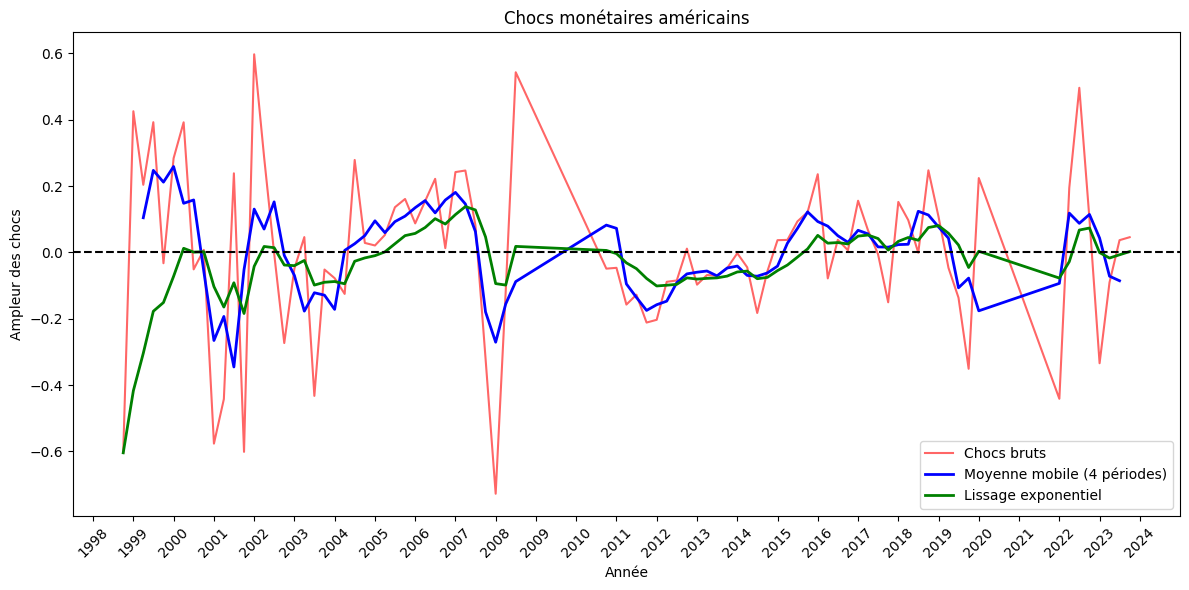

In [203]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

#data_US_clean.index = data_US_clean.index.to_timestamp()


# Appliquer une moyenne glissante sur 6 p√©riodes (ajuster selon les besoins)
data_US_clean['monetary_shocks_smooth'] = data_US_clean['monetary_shocks_2lags_v2'].rolling(window=4, center=True).mean()
data_US_clean['monetary_shocks_ewma'] = data_US_clean['monetary_shocks_2lags_v2'].ewm(span=10, adjust=False).mean()

# Tracer les s√©ries
plt.figure(figsize=(12, 6))
plt.plot(data_US_clean.index, data_US_clean['monetary_shocks_2lags_v2'], color='red', alpha=0.6, label='Chocs bruts')
plt.plot(data_US_clean.index, data_US_clean['monetary_shocks_smooth'], color='blue', linewidth=2, label='Moyenne mobile (4 p√©riodes)')
plt.plot(data_US_clean.index, data_US_clean['monetary_shocks_ewma'], color='green', linewidth=2, label='Lissage exponentiel')
plt.axhline(0, linestyle="--", color="black")
plt.xlabel('Ann√©e')
plt.ylabel('Ampleur des chocs')
plt.title('Chocs mon√©taires am√©ricains')
plt.legend()

# üëâ Personnaliser l'axe des X pour afficher une ann√©e tous les ans
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.YearLocator(1))  # Ticks tous les ans
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  # Format affich√© : 2020, 2021, etc.
plt.xticks(rotation=45)

plt.tight_layout()
plt.savefig("monetary_shocks_2lags_v2.png", dpi=300)
plt.show()

### 5√®me essai: sans l'inflation, avec 2 lags <a class="anchor" id="partie35"></a>

In [204]:
import pandas as pd
import statsmodels.api as sm

# Supprimer les lignes avec NaN ou Inf
data_US_clean = data_US_clean.apply(pd.to_numeric, errors='coerce')

# D√©finition de Y (variable d√©pendante)
Y = data_US_clean['Policy rate']

# S√©lectionner toutes les colonnes explicatives
X = data_US_clean[['Policy rate_lag1','Policy rate_lag2',
                   
                   'GDPC1_log', 'GDPC1_lag1_log', 'GDPC1_lag2_log', 
                   'spread corporate','spread corporate_lag1', 'spread corporate_lag2',
                   'time_squared']]

# Ajouter une constante
X = sm.add_constant(X)

# R√©gression
model = sm.OLS(Y, X).fit()
model_5=model

# Extraire les r√©sidus comme chocs mon√©taires
data_US_clean['monetary_shocks_2lags_v3'] = model.resid

# Ajouter les √©toiles de significativit√©
def significance_stars(p):
    if p < 0.01:
        return '***'
    elif p < 0.05:
        return '**'
    elif p < 0.10:
        return '*'
    else:
        return ''

# Construire un DataFrame avec les r√©sultats format√©s
coef_table = pd.DataFrame({
    "Coefficient": model.params,
    "Std. Error": model.bse,
    "t-Statistic": model.tvalues,
    "P-Value": model.pvalues
})

# Ajouter les √©toiles aux coefficients
coef_table["Significance"] = coef_table["P-Value"].apply(significance_stars)
coef_table["Coefficient"] = coef_table["Coefficient"].round(4).astype(str) + coef_table["Significance"]

# R√©organiser les colonnes pour l'affichage
coef_table = coef_table[["Coefficient", "Std. Error", "t-Statistic", "P-Value"]]

# Renommer les colonnes en ajoutant le format LaTeX pour du texte en gras
coef_table.columns = [r"\textbf{Coefficient}", r"\textbf{Std. Error}", r"\textbf{t-Statistic}", r"\textbf{P-Value}"]

# Ajouter les statistiques globales en haut de la table
stats_dict = {
    r"\textbf{R-squared}": round(model.rsquared, 4),
    r"\textbf{Adj. R-squared}": round(model.rsquared_adj, 4),
    r"\textbf{F-statistic}": round(model.fvalue, 4),
    r"\textbf{Prob (F-statistic)}": round(model.f_pvalue, 4),
    r"\textbf{Observations}": int(model.nobs)
}

# Convertir en DataFrame et transposer pour affichage
stats_table = pd.DataFrame.from_dict(stats_dict, orient='index', columns=["Value"]).T

# Convertir en LaTeX avec statistiques au d√©but
latex_table = stats_table.to_latex(index=False, escape=False) + "\n" + coef_table.to_latex(index=True, escape=False)

# Sauvegarder en fichier .tex
with open("regression_results_2_lags_v3.tex", "w") as f:
    f.write(latex_table)

# Afficher le r√©sum√© de la r√©gression
print(model.summary())


# Enregistrer les R carr√© ajst√©, AIC et BIC pour comparer les mod√®les ensuite
R_5 = model.rsquared
R_adj_5 = model.rsquared_adj
aic_5 = model.aic
bic_5 = model.bic

                            OLS Regression Results                            
Dep. Variable:            Policy rate   R-squared:                       0.983
Model:                            OLS   Adj. R-squared:                  0.981
Method:                 Least Squares   F-statistic:                     492.0
Date:                Thu, 08 May 2025   Prob (F-statistic):           1.44e-63
Time:                        16:02:15   Log-Likelihood:                -7.2154
No. Observations:                  86   AIC:                             34.43
Df Residuals:                      76   BIC:                             58.97
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    11.46

In [205]:
# S√©lection du mod√®le : 

# Liste des num√©ros de mod√®les
model_numbers = [1,2, 3, 4, 5]

# Construction du tableau
tableau = pd.DataFrame({
    'Mod√®le': [f'Essai {i}' for i in model_numbers],
    'R¬≤': [globals()[f'R_{i}'] for i in model_numbers],
    'R¬≤ ajust√©': [globals()[f'R_adj_{i}'] for i in model_numbers],
    'AIC': [globals()[f'aic_{i}'] for i in model_numbers],
    'BIC': [globals()[f'bic_{i}'] for i in model_numbers]
})

# Affichage
display(tableau)


tableau.to_latex(
    'tableau_modeles.tex',
    index=False,
    caption='R√©sum√© des crit√®res de s√©lection des mod√®les',
    label='tab:regression_summary',
    float_format="%.3f"     # trois d√©cimales pour les nombres
)

Mod√®le        R¬≤  R¬≤ ajust√©        AIC        BIC
0  Essai 1  0.988387   0.984813  24.308289  75.849583
1  Essai 2  0.985925   0.983611  24.840693  56.747208
2  Essai 3  0.971900   0.968981  76.298914  98.388040
3  Essai 4  0.985293   0.983551  22.620408  47.163881
4  Essai 5  0.983128   0.981130  34.430721  58.974194

## 2√®me partie du mod√®le: impact des chocs mon√©taires <a class="anchor" id="partie4"></a>

Nous allons maintenant estimer avec une r√©gression de panel l'impact des chocs de politique mon√©taire identifi√©s, sur diff√©rentes variables (GDP, employment ? ...). La m√©thode utilis√© est celle de Jorda (2005), la m√©thode de projection locale. Cela consiste √† "estimer des projections locales √† chaque p√©riode au lieu d'extrapoler sur des horizons lointains √† partir d'un mod√®le."
Nous allons estimer une √©quation de la forme suivante, comme dans Iacoviello & Navarro (2018) :

$$
y_{i,t+h} = \alpha_{i,h} + \beta_h u_t + A_{h,i} Z_{i,t} + \varepsilon_{i,t+h}
$$

o√π :

- $y_{i,t+h}$ est le PIB du pays $ i $ au temps $t$,
- $\alpha_{i,h} $ est un effet fixe sp√©cifique au pays,
- $u_t$ est le choc mon√©taire,
- $Z_{i,t}$  repr√©sente les variables de contr√¥le : 4 lags du PIB, des tendances lin√©aire et quadratique,
- $\varepsilon_{i,t+h}$  est le terme d'erreur.

Pour chaque h il faut estimer un $\beta_h$, ensuite il faut faire les IRF (fonctions de r√©ponse impulsionnelle) pour les diff√©rents Y qu'on utilise.


Pour les variables de contr√¥le, il faut s√ªrement tester lesquelles sont les meilleures, ne pas forc√©ment reproduire exactement le mod√®le.

On a des donn√©es trimestrielles donc on prend h de 0 √† 4 ou 8

In [206]:
import pandas as pd
data=pd.read_excel("../Donn√©es_produites/base_de_donn√©es_v1.xlsx")

In [207]:
# üîç √âtape 1 : V√©rification des colonnes
print("Colonnes initiales :", data.columns.tolist())

# Identifier automatiquement la colonne temporelle si nomm√©e "Unnamed: 0" ou similaire
time_col_candidates = [col for col in data.columns if "unnamed" in col.lower() or "time" in col.lower()]
if time_col_candidates:
    time_col = time_col_candidates[0]
    data = data.rename(columns={time_col: "Time"})
else:
    raise ValueError("Impossible de trouver la colonne 'Time' dans le fichier Excel.")

# üîÅ √âtape 2 : Conversion au format long
df_long = data.melt(id_vars="Time", var_name="Variable_Country", value_name="Value")

# üîç √âtape 3 : V√©rification du format des noms
# Affiche quelques exemples pour s‚Äôassurer du format attendu
print("\nExemples de noms de colonnes fusionn√©es :", df_long["Variable_Country"].unique()[:5])

# Appliquer un split seulement si un underscore est pr√©sent
split_ok = df_long["Variable_Country"].str.contains("_")
df_valid = df_long[split_ok].copy()

# S√©parer en deux colonnes : Variable + Country
df_valid[["Variable", "Country"]] = df_valid["Variable_Country"].str.rsplit("_", n=1, expand=True)

# ‚ö†Ô∏è Facultatif : alerter sur les noms qui n'ont pas pu √™tre s√©par√©s
if not split_ok.all():
    print("Colonnes ignor√©es car mal nomm√©es :", df_long.loc[~split_ok, "Variable_Country"].unique())

# R√©organiser les colonnes
df_final = df_valid[["Time", "Country", "Variable", "Value"]]

# ‚úÖ Affichage final
print("\nAper√ßu du DataFrame long format :")
print(df_final.head())

# Sauvegarde dans data pour compatibilit√© avec le reste de ton notebook
data = df_final.copy()


Colonnes initiales : ['Unnamed: 0', 'CPI_Austria', 'PIB_Austria', 'LT_IR_Austria', 'ST_IR_Austria', 'WH_Austria', 'P_Growth_Austria', 'CPI_Belgium', 'PIB_Belgium', 'LT_IR_Belgium', 'ST_IR_Belgium', 'WH_Belgium', 'P_Growth_Belgium', 'CPI_Bulgaria', 'PIB_Bulgaria', 'LT_IR_Bulgaria', 'ST_IR_Bulgaria', 'WH_Bulgaria', 'P_Growth_Bulgaria', 'CPI_Czechia', 'PIB_Czechia', 'LT_IR_Czechia', 'ST_IR_Czechia', 'WH_Czechia', 'P_Growth_Czechia', 'CPI_Denmark', 'PIB_Denmark', 'LT_IR_Denmark', 'ST_IR_Denmark', 'WH_Denmark', 'P_Growth_Denmark', 'CPI_Estonia', 'PIB_Estonia', 'LT_IR_Estonia', 'ST_IR_Estonia', 'WH_Estonia', 'P_Growth_Estonia', 'CPI_Finland', 'PIB_Finland', 'LT_IR_Finland', 'ST_IR_Finland', 'WH_Finland', 'P_Growth_Finland', 'CPI_France', 'PIB_France', 'LT_IR_France', 'ST_IR_France', 'WH_France', 'P_Growth_France', 'CPI_Germany', 'PIB_Germany', 'LT_IR_Germany', 'ST_IR_Germany', 'WH_Germany', 'P_Growth_Germany', 'CPI_Greece', 'PIB_Greece', 'LT_IR_Greece', 'ST_IR_Greece', 'WH_Greece', 'P_Growth

In [208]:
#data
#df_target

### Estimation de l'impact du choc sur le PIB am√©ricain <a class="anchor" id="partie41"></a>

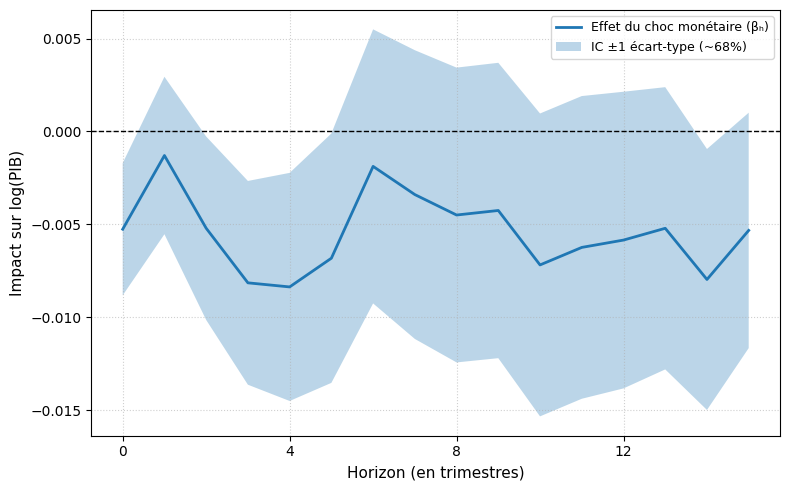

In [209]:

H = 15  # nombre d'horizons
betas = []
stderr_list = []

# ==============================
# 2) Boucle sur les horizons h = 0 √† H
# ==============================
for h in range(H + 1):
    # Copie du DataFrame pour chaque horizon (pour √©viter des colonnes temporaires cumul√©es)
    df = data_US_clean.copy()

    # a) Cr√©ation des lags du PIB
    for lag in range(1, 5):
        df[f'GDP_lag{lag}'] = df['GDPC1_log'].shift(lag)

    # b) Ajout d'une tendance lin√©aire et quadratique
    df['trend'] = range(len(df))
    df['trend_sq'] = df['trend'] ** 2

    # c) Variable d√©pendante : PIB √† l‚Äôhorizon h (d√©calage de -h)
    df[f'GDP_lead_{h}'] = df['GDPC1_log'].shift(-h)

    # d) Nettoyage des lignes NaN (pour √©viter de perdre l'√©quation)
    df_model = df.dropna(subset=[
        f'GDP_lead_{h}',        # la variable d√©pendante (PIB d√©cal√©)
        'monetary_shocks',
        'GDP_lag1', 'GDP_lag2', 'GDP_lag3', 'GDP_lag4'
    ])

    # e) Variable d√©pendante et explicatives
    Y = df_model[f'GDP_lead_{h}']
    X = df_model[['monetary_shocks', 
                  'GDP_lag1', 'GDP_lag2', 'GDP_lag3', 'GDP_lag4',
                  'trend', 'trend_sq']]
    X = sm.add_constant(X)

    # f) Estimation de la r√©gression OLS pour l‚Äôhorizon h
    model = sm.OLS(Y, X).fit()

    # g) Extraction du coefficient du choc et de son √©cart-type
    beta_h = model.params['monetary_shocks']
    stderr_h = model.bse['monetary_shocks']

    # h) Stockage
    betas.append(beta_h)
    stderr_list.append(stderr_h)

# ======================================
# 3) Calcul d'un intervalle de confiance (IC 68%)
#    (Pour 1 √©cart-type, ‚âà 68% si distribution normale)
# ======================================
lower = [b - s for b, s in zip(betas, stderr_list)]
upper = [b + s for b, s in zip(betas, stderr_list)]

# ======================================
# 4) Trac√© de la Fonction de R√©ponse (IRF)
# ======================================
horizons = range(H + 1)

plt.figure(figsize=(8, 5))

# Courbe principale : coefficient Œ≤·µ£
plt.plot(horizons, betas, linewidth=2, label="Effet du choc mon√©taire (Œ≤‚Çï)")

# Intervalle de confiance
plt.fill_between(horizons, lower, upper, alpha=0.3, label="IC ¬±1 √©cart-type (~68%)")

# Ligne horizontale √† 0
plt.axhline(0, color='black', linestyle='--', linewidth=1)

# Mise en forme
plt.xlabel("Horizon (en trimestres)", fontsize=11)
plt.ylabel("Impact sur log(PIB)", fontsize=11)
plt.xticks(np.arange(0, H+1, step=4))
plt.grid(True, linestyle=':', alpha=0.6)
plt.legend(loc="best", fontsize=9)
plt.tight_layout()
plt.savefig("reponse US gdp1.png", dpi=300)
plt.show()


### R√©ponse des PIBs des pays europ√©ens aux chocs <a class="anchor" id="partie42"></a>

In [210]:
# Classification des pays en cat√©gories
categories = {
    "√âconomie en d√©veloppement": [
        "Czechia", "Lithuania", "Latvia", "Poland", "Bulgaria", "Slovakia",
        "Hungary", "Slovenia", "Iceland", "Estonia", "Romania"
    ],
    "Grosse √©conomie d√©velopp√©e": [
        "Germany", "United Kingdom", "France", "Italy", "Spain", "Netherlands"
    ],
    "Petite √©conomie d√©velopp√©e": [
        "Austria", "Belgium", "Denmark", "Greece", "Finland", "Ireland",
        "Luxembourg", "Norway", "Portugal", "Sweden", "Switzerland"
    ]
}

/tmp/ipykernel_19990/2840106001.py:29: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_target["Time"] = pd.to_datetime(df_target["Time"])



üìã R√©sultats par pays :
        Country                    Category  Coef_monetary_shock   P_value  \
14       Latvia   √âconomie en d√©veloppement             0.033043  0.214865   
11      Iceland   √âconomie en d√©veloppement             0.031056  0.244517   
5       Estonia   √âconomie en d√©veloppement             0.026255  0.143025   
25       Sweden  Petite √©conomie d√©velopp√©e             0.021453  0.085699   
16   Luxembourg  Petite √©conomie d√©velopp√©e             0.014577  0.275334   
3       Czechia   √âconomie en d√©veloppement             0.013926  0.525180   
15    Lithuania   √âconomie en d√©veloppement             0.013628  0.532347   
22     Slovakia   √âconomie en d√©veloppement             0.013606  0.563382   
4       Denmark  Petite √©conomie d√©velopp√©e             0.013133  0.156674   
12      Ireland  Petite √©conomie d√©velopp√©e             0.010439  0.578122   
20     Portugal  Petite √©conomie d√©velopp√©e             0.008701  0.410253   
18       

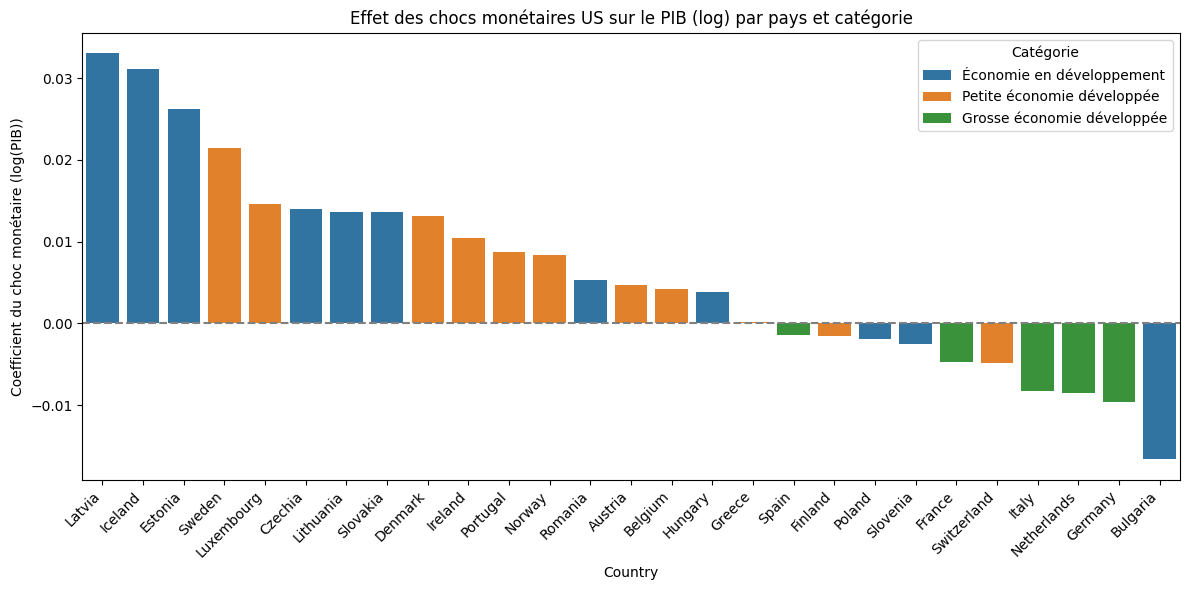

In [211]:
import seaborn as sns
def get_category(country):
    for cat, countries in categories.items():
        if country in countries:
            return cat
    return "Autre"

# --- 2. Filtrer les donn√©es sur le PIB et prendre le log ---
target_variable = "PIB"
df_target = data[data["Variable"] == target_variable].copy()
df_target = df_target[df_target["Value"] > 0]  # s√©curit√© pour log
df_target["Value"] = np.log(df_target["Value"])

# --- 3. Trier et ajouter lags + tendances ---
df_target = df_target.sort_values(["Country", "Time"])

for lag in range(1, 5):
    df_target[f"lag{lag}"] = df_target.groupby("Country")["Value"].shift(lag)

df_target["trend"] = df_target.groupby("Country").cumcount() + 1
df_target["trend_sq"] = df_target["trend"] ** 2
df_target["Category"] = df_target["Country"].apply(get_category)

# Il faut merger ces donn√©es avec les chocs mon√©taires obtenus : 
data_US_clean_reset = data_US_clean.reset_index()
monetary_cols = [col for col in data_US_clean_reset.columns if col.startswith("monetary_shocks")]
monetary_df = data_US_clean_reset[["date"] + monetary_cols].copy()
monetary_df = monetary_df.rename(columns={"date": "Time"})
df_target["Time"] = pd.to_datetime(df_target["Time"])
monetary_df["Time"] = pd.to_datetime(monetary_df["Time"])

df_target = df_target.merge(monetary_df, on="Time", how="left")



# --- 4. R√©gressions pays par pays ---
results = []
required_cols = ["Value", "monetary_shocks", "lag1", "lag2", "lag3", "lag4", "trend", "trend_sq"]

for country in df_target["Country"].unique():
    sub = df_target[df_target["Country"] == country].dropna(subset=required_cols)

    if len(sub) < 10:
        continue

    X = sub[["monetary_shocks", "lag1", "lag2", "lag3", "lag4", "trend", "trend_sq"]]
    X = sm.add_constant(X)
    y = sub["Value"]

    model = sm.OLS(y, X).fit()
    coef = model.params["monetary_shocks"]
    pval = model.pvalues["monetary_shocks"]
    category = get_category(country)

    results.append({
        "Country": country,
        "Category": category,
        "Coef_monetary_shock": coef,
        "P_value": pval,
        "R_squared": model.rsquared
    })



# --- 5. R√©sultats ---
results_df = pd.DataFrame(results).sort_values("Coef_monetary_shock", ascending=False)

print("\nüìã R√©sultats par pays :")
print(results_df)
cols_to_export = [col for col in results_df.columns if col != "Category"]
results_df[cols_to_export].to_latex("resultats_pays_1.tex", index=False, float_format="%.4f")

# --- 6. Graphique group√© par cat√©gorie ---
plt.figure(figsize=(12, 6))
sns.barplot(data=results_df, x="Country", y="Coef_monetary_shock", hue="Category", dodge=False)
plt.axhline(0, color="gray", linestyle="--")
plt.title("Effet des chocs mon√©taires US sur le PIB (log) par pays et cat√©gorie")
plt.ylabel("Coefficient du choc mon√©taire (log(PIB))")
plt.xticks(rotation=45, ha="right")
plt.legend(title="Cat√©gorie")
plt.tight_layout()
plt.savefig("choc_pays_categorie_PIB.png", dpi=300)
plt.show()

### R√©ponse de l'inflation des pays europ√©ens aux chocs <a class="anchor" id="partie43"></a>

/tmp/ipykernel_19990/649745516.py:28: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_target["Time"] = pd.to_datetime(df_target["Time"])



üìã R√©sultats par pays :
        Country                    Category  Coef_monetary_shock   P_value  \
2      Bulgaria   √âconomie en d√©veloppement             0.580138  0.426735   
12      Ireland  Petite √©conomie d√©velopp√©e             0.347545  0.189416   
16   Luxembourg  Petite √©conomie d√©velopp√©e             0.233867  0.518629   
23     Slovenia   √âconomie en d√©veloppement             0.221717  0.495583   
8       Germany  Grosse √©conomie d√©velopp√©e             0.183335  0.485414   
10      Hungary   √âconomie en d√©veloppement             0.115234  0.830399   
1       Belgium  Petite √©conomie d√©velopp√©e             0.104291  0.749182   
4       Denmark  Petite √©conomie d√©velopp√©e             0.103402  0.709875   
26  Switzerland  Petite √©conomie d√©velopp√©e             0.090583  0.720569   
18       Norway  Petite √©conomie d√©velopp√©e             0.065262  0.856626   
17  Netherlands  Grosse √©conomie d√©velopp√©e             0.011293  0.976852   
24    

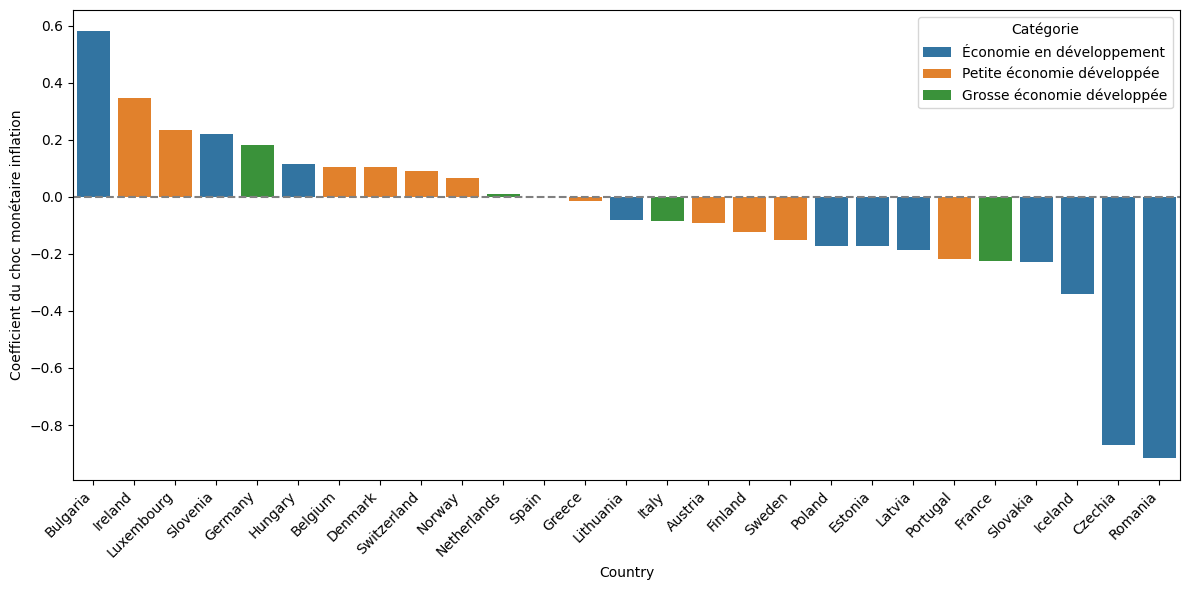

In [212]:
import seaborn as sns
def get_category(country):
    for cat, countries in categories.items():
        if country in countries:
            return cat
    return "Autre"

# --- 2. Filtrer les donn√©es sur linflation ---
target_variable = "inflation"
df_target = data[data["Variable"] == target_variable].copy()

# --- 3. Trier et ajouter lags + tendances ---
df_target = df_target.sort_values(["Country", "Time"])

for lag in range(1, 5):
    df_target[f"lag{lag}"] = df_target.groupby("Country")["Value"].shift(lag)

df_target["trend"] = df_target.groupby("Country").cumcount() + 1
df_target["trend_sq"] = df_target["trend"] ** 2
df_target["Category"] = df_target["Country"].apply(get_category)
df_target = df_target[df_target["Category"] != "Autre"] # pour supprimer les US

# Il faut merger ces donn√©es avec les chocs mon√©taires obtenus : 
data_US_clean_reset = data_US_clean.reset_index()
monetary_cols = [col for col in data_US_clean_reset.columns if col.startswith("monetary_shocks")]
monetary_df = data_US_clean_reset[["date"] + monetary_cols].copy()
monetary_df = monetary_df.rename(columns={"date": "Time"})
df_target["Time"] = pd.to_datetime(df_target["Time"])
monetary_df["Time"] = pd.to_datetime(monetary_df["Time"])

df_target = df_target.merge(monetary_df, on="Time", how="left")



# --- 4. R√©gressions pays par pays ---
results = []
required_cols = ["Value", "monetary_shocks", "lag1", "lag2", "lag3", "lag4", "trend", "trend_sq"]

for country in df_target["Country"].unique():
    sub = df_target[df_target["Country"] == country].dropna(subset=required_cols)

    if len(sub) < 10:
        continue

    X = sub[["monetary_shocks", "lag1", "lag2", "lag3", "lag4", "trend", "trend_sq"]]
    X = sm.add_constant(X)
    y = sub["Value"]

    model = sm.OLS(y, X).fit()
    coef = model.params["monetary_shocks"]
    pval = model.pvalues["monetary_shocks"]
    category = get_category(country)

    results.append({
        "Country": country,
        "Category": category,
        "Coef_monetary_shock": coef,
        "P_value": pval,
        "R_squared": model.rsquared
    })



# --- 5. R√©sultats ---
results_df = pd.DataFrame(results).sort_values("Coef_monetary_shock", ascending=False)

print("\nüìã R√©sultats par pays :")
print(results_df)
cols_to_export = [col for col in results_df.columns if col != "Category"]
results_df[cols_to_export].to_latex("resultats_pays_inflation.tex", index=False, float_format="%.4f")

# --- 6. Graphique group√© par cat√©gorie ---
plt.figure(figsize=(12, 6))
sns.barplot(data=results_df, x="Country", y="Coef_monetary_shock", hue="Category", dodge=False)
plt.axhline(0, color="gray", linestyle="--")
plt.ylabel("Coefficient du choc mon√©taire inflation")
plt.xticks(rotation=45, ha="right")
plt.legend(title="Cat√©gorie")
plt.tight_layout()
plt.savefig("choc_pays_categorie_inflation.png", dpi=300)
plt.show()

### R√©ponse des taux directeurs europ√©ens aux chocs <a class="anchor" id="partie44"></a>

/tmp/ipykernel_19990/823461552.py:22: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_target["Time"] = pd.to_datetime(df_target["Time"])



üìã R√©sultats par pays :
        Country                    Category  Coef_monetary_shock   P_value  \
23     Slovenia   √âconomie en d√©veloppement             0.747344  0.019615   
2      Bulgaria   √âconomie en d√©veloppement             0.692572  0.191043   
16   Luxembourg  Petite √©conomie d√©velopp√©e             0.448445  0.026618   
12      Ireland  Petite √©conomie d√©velopp√©e             0.447141  0.012413   
13        Italy  Grosse √©conomie d√©velopp√©e             0.390946  0.027743   
24        Spain  Grosse √©conomie d√©velopp√©e             0.385137  0.030248   
20     Portugal  Petite √©conomie d√©velopp√©e             0.383477  0.031059   
9        Greece  Petite √©conomie d√©velopp√©e             0.380123  0.030835   
15    Lithuania   √âconomie en d√©veloppement             0.379113  0.111365   
14       Latvia   √âconomie en d√©veloppement             0.368266  0.080238   
17  Netherlands  Grosse √©conomie d√©velopp√©e             0.366648  0.039602   
6      

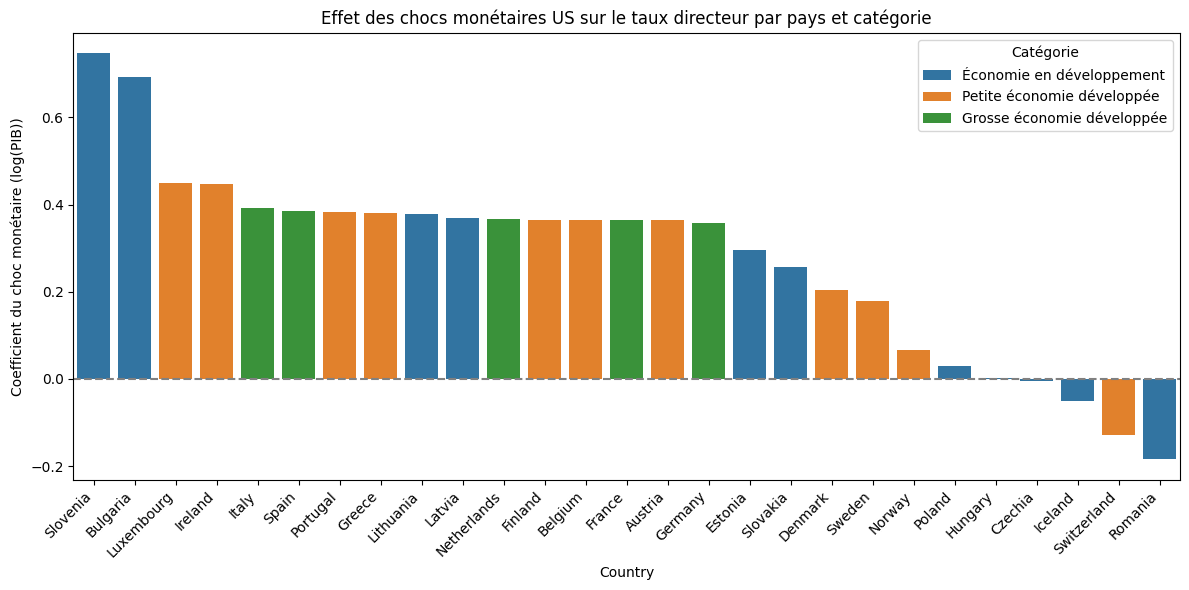

In [213]:
# --- 2. Filtrer les donn√©es sur le PIB et prendre le log ---
target_variable = "ST_IR"
df_target = data[data["Variable"] == target_variable].copy()
df_target = df_target[df_target["Value"] > 0]  # s√©curit√© pour log
df_target["Value"] = np.log(df_target["Value"])

# --- 3. Trier et ajouter lags + tendances ---
df_target = df_target.sort_values(["Country", "Time"])

for lag in range(1, 5):
    df_target[f"lag{lag}"] = df_target.groupby("Country")["Value"].shift(lag)

df_target["trend"] = df_target.groupby("Country").cumcount() + 1
df_target["trend_sq"] = df_target["trend"] ** 2
df_target["Category"] = df_target["Country"].apply(get_category)

# Il faut merger ces donn√©es avec les chocs mon√©taires obtenus : 
data_US_clean_reset = data_US_clean.reset_index()
monetary_cols = [col for col in data_US_clean_reset.columns if col.startswith("monetary_shocks")]
monetary_df = data_US_clean_reset[["date"] + monetary_cols].copy()
monetary_df = monetary_df.rename(columns={"date": "Time"})
df_target["Time"] = pd.to_datetime(df_target["Time"])
monetary_df["Time"] = pd.to_datetime(monetary_df["Time"])

df_target = df_target.merge(monetary_df, on="Time", how="left")



# --- 4. R√©gressions pays par pays ---
results = []
required_cols = ["Value", "monetary_shocks", "lag1", "lag2", "lag3", "lag4", "trend", "trend_sq"]

for country in df_target["Country"].unique():
    sub = df_target[df_target["Country"] == country].dropna(subset=required_cols)

    if len(sub) < 10:
        continue

    X = sub[["monetary_shocks", "lag1", "lag2", "lag3", "lag4", "trend", "trend_sq"]]
    X = sm.add_constant(X)
    y = sub["Value"]

    model = sm.OLS(y, X).fit()
    coef = model.params["monetary_shocks"]
    pval = model.pvalues["monetary_shocks"]
    category = get_category(country)

    results.append({
        "Country": country,
        "Category": category,
        "Coef_monetary_shock": coef,
        "P_value": pval,
        "R_squared": model.rsquared
    })



# --- 5. R√©sultats ---
results_df = pd.DataFrame(results).sort_values("Coef_monetary_shock", ascending=False)

print("\nüìã R√©sultats par pays :")
print(results_df)
cols_to_export = [col for col in results_df.columns if col != "Category"]
results_df[cols_to_export].to_latex("resultats_pays_1.tex", index=False, float_format="%.4f")

# --- 6. Graphique group√© par cat√©gorie ---
plt.figure(figsize=(12, 6))
sns.barplot(data=results_df, x="Country", y="Coef_monetary_shock", hue="Category", dodge=False)
plt.axhline(0, color="gray", linestyle="--")
plt.title("Effet des chocs mon√©taires US sur le taux directeur par pays et cat√©gorie")
plt.ylabel("Coefficient du choc mon√©taire (log(PIB))")
plt.xticks(rotation=45, ha="right")
plt.legend(title="Cat√©gorie")
plt.tight_layout()
plt.savefig("choc_pays_categorie_taux.png", dpi=300)
plt.show()

IRF des pays europ√©ens

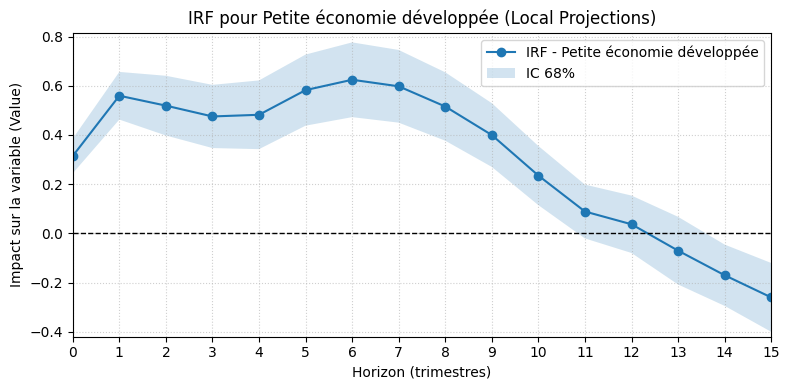

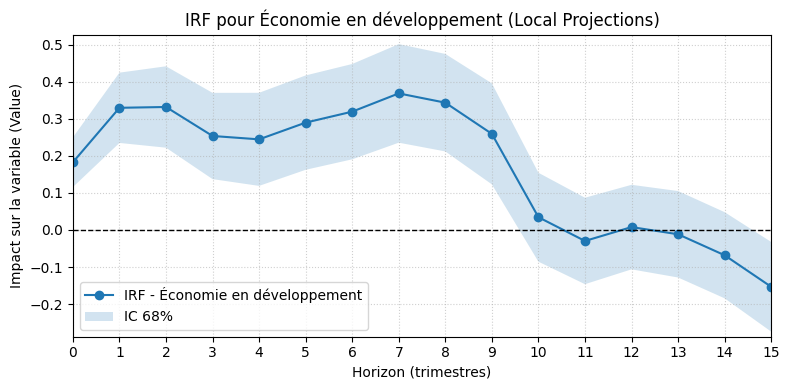

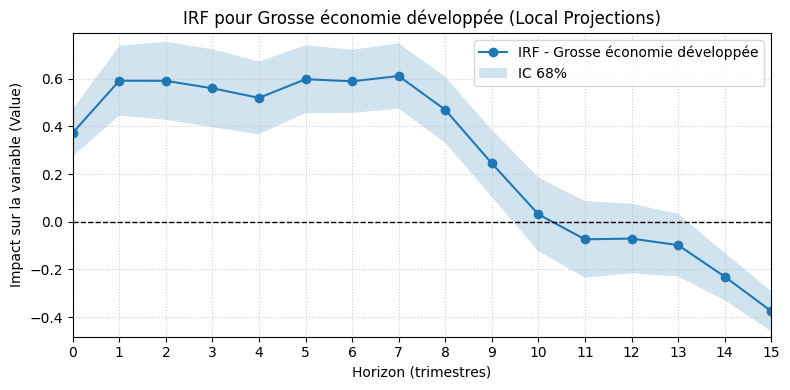

In [214]:
# ===================================
# 1) Param√®tres
# ===================================
horizons = range(16)  # de 0 √† 15

# On cr√©e des structures pour stocker les IRFs par cat√©gorie :
results_irf_cat = {cat: [] for cat in df_target["Category"].unique()}
conf_ints_cat = {cat: [] for cat in df_target["Category"].unique()}

# ===================================
# 2) Estimation des IRF par cat√©gorie et par horizon
# ===================================
for h in horizons:
    # -----------------------------------
    # a) On cr√©e un DataFrame temporaire
    #    avec la variable d√©pendante "lead h"
    # -----------------------------------
    df_shifted = df_target.copy()

    # Pour chaque pays, on d√©cale Value de -h
    df_shifted[f"lead_{h}"] = df_shifted.groupby("Country")["Value"].shift(-h)

    # On cr√©e les lags 1 √† 4 de la variable Value
    for lag in range(1, 5):
        df_shifted[f"lag{lag}"] = df_shifted.groupby("Country")["Value"].shift(lag)

    # Tendance lin√©aire + quadratique (par pays)
    df_shifted["trend"] = df_shifted.groupby("Country").cumcount() + 1
    df_shifted["trend_sq"] = df_shifted["trend"] ** 2

    # -----------------------------------
    # b) Pour chaque cat√©gorie, on estime la r√©gression:
    #    lead_{h} = alpha + beta_h * Shock_t + sum_{p=1}^4 gamma_p * lag p + ...
    # -----------------------------------
    for cat in results_irf_cat.keys():
        # Filtrer la cat√©gorie
        sub = df_shifted[df_shifted["Category"] == cat].dropna(
            subset=[
                f"lead_{h}",
                "monetary_shocks",
                "lag1", "lag2", "lag3", "lag4",
                "trend", "trend_sq"
            ]
        )

        # S'il y a trop peu d'observations, on saute
        if len(sub) < 10:
            results_irf_cat[cat].append(np.nan)
            conf_ints_cat[cat].append((np.nan, np.nan))
            continue

        # Variables d√©pendante / explicatives
        Y = sub[f"lead_{h}"]
        X = sub[[
            "monetary_shocks",
            "lag1", "lag2", "lag3", "lag4",
            "trend", "trend_sq"
        ]]
        X = sm.add_constant(X)

        # R√©gression OLS (avec erreurs st. robustes type HC1)
        model = sm.OLS(Y, X).fit(cov_type='HC1')

        # Extraction du coefficient du choc + son √©cart-type
        beta = model.params["monetary_shocks"]
        stderr = model.bse["monetary_shocks"]

        # Stockage de la valeur ponctuelle et de l'IC (68% ‚âà ¬±1 √©cart-type)
        results_irf_cat[cat].append(beta)
        conf_ints_cat[cat].append((beta - stderr, beta + stderr))

# ===================================
# 3) Affichage des IRFs cat√©gorie par cat√©gorie
# ===================================
for cat in results_irf_cat:
    irf = results_irf_cat[cat]         # la suite des betas pour h = 0..15
    ci = np.array(conf_ints_cat[cat])  # la suite des IC

    # V√©rifie s‚Äôil n‚Äôy a que des NaN (pas assez de donn√©es)
    if all(np.isnan(irf)):
        print(f"‚è≠Ô∏è  Pas assez de donn√©es pour {cat}")
        continue

    lower, upper = ci[:, 0], ci[:, 1]

    # D√©finir des bornes dynamiques, en √©vitant le cas all-NaN
    valid_lower = lower[~np.isnan(lower)]
    valid_upper = upper[~np.isnan(upper)]
    if len(valid_lower) == 0 or len(valid_upper) == 0:
        print(f"‚è≠Ô∏è  Pas assez de donn√©es valides pour {cat}")
        continue

    y_min = valid_lower.min() - 0.05*abs(valid_lower.min())
    y_max = valid_upper.max() + 0.05*abs(valid_upper.max())

    # Trac√© de l'IRF
    plt.figure(figsize=(8, 4))
    plt.plot(horizons, irf, marker='o', label=f"IRF - {cat}")
    plt.fill_between(horizons, lower, upper, alpha=0.2, label="IC 68%")
    plt.axhline(0, color='black', linestyle='--', linewidth=1)

    plt.title(f"IRF pour {cat} (Local Projections)")
    plt.xlabel("Horizon (trimestres)")
    plt.ylabel("Impact sur la variable (Value)")
    plt.ylim(y_min, y_max)
    plt.xlim(0, max(horizons))
    plt.xticks(horizons)
    plt.grid(True, linestyle=':', alpha=0.6)
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"irf_{cat}.png", dpi=300)  # ‚Üê ici on ajoute le nom de la cat√©gorie
    plt.show()


   


Regression panel pour IRF PIB √©trangers

In [215]:
pip install --upgrade linearmodels

Note: you may need to restart the kernel to use updated packages.


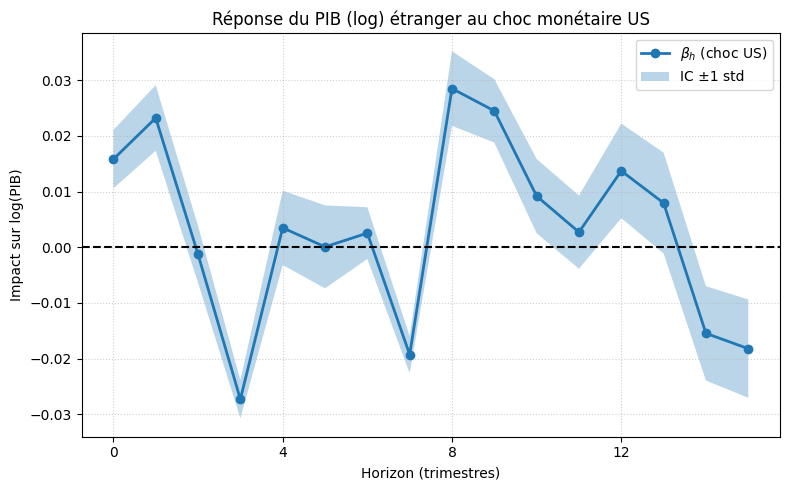

In [216]:
from linearmodels.panel import PanelOLS
# ------------------------------------------------
# 0) Pr√©parer les chocs mon√©taires US
# ------------------------------------------------
df_shocks = data_US_clean.reset_index()[["date", "monetary_shocks"]].copy()
df_shocks = df_shocks.rename(columns={"date": "Time", "monetary_shocks": "shock_US"})

# Convertir Time en datetime avec p√©riode trimestrielle correcte
df_shocks["Time"] = pd.PeriodIndex(df_shocks["Time"], freq="Q").to_timestamp()

# ------------------------------------------------
# 1) Corriger le format de data["Time"] ‚Üí datetime trimestriel
# Nettoie et convertit "1995-Q1" ‚Üí "1995Q1" ‚Üí datetime
data["Time"] = data["Time"].astype(str).str.replace("-", "")
data["Time"] = pd.PeriodIndex(data["Time"], freq="Q").to_timestamp()


# ------------------------------------------------
# 2) Fusion avec les chocs
# ------------------------------------------------
df_merged = pd.merge(data, df_shocks, on="Time", how="inner")

# ------------------------------------------------
# 3) Filtrer le PIB (log)
# ------------------------------------------------
df_pib = df_merged[df_merged["Variable"] == "PIB"].copy()
df_pib = df_pib[df_pib["Value"] > 0]
df_pib["Value"] = np.log(df_pib["Value"])

# ------------------------------------------------
# 4) Panel index + s√©curit√© Time
# ------------------------------------------------
df_pib = df_pib.sort_values(["Country", "Time"]).copy()
df_pib["Time"] = pd.to_datetime(df_pib["Time"])  # s√©curit√© explicite
df_pib = df_pib.set_index(["Country", "Time"])

# ------------------------------------------------
# 5) Projections locales fa√ßon Jord√†
# ------------------------------------------------
H = 15
betas = []
stderr = []

for h in range(H + 1):
    df_lp = df_pib.copy()
    df_lp[f"y_lead{h}"] = df_lp.groupby(level="Country")["Value"].shift(-h)

    for lag in range(1, 5):
        df_lp[f"y_lag{lag}"] = df_lp.groupby(level="Country")["Value"].shift(lag)

    df_lp = df_lp.reset_index()
    df_lp["trend"] = df_lp.groupby("Country").cumcount() + 1
    df_lp["trend_sq"] = df_lp["trend"] ** 2
    df_lp = df_lp.set_index(["Country", "Time"])

    needed = [f"y_lead{h}", "shock_US"] + [f"y_lag{k}" for k in range(1, 5)]
    df_model = df_lp.dropna(subset=needed).copy()

    Y = df_model[f"y_lead{h}"]
    X_cols = ["shock_US", "y_lag1", "y_lag2", "y_lag3", "y_lag4", "trend", "trend_sq"]
    df_model["const"] = 1.0
    X_cols = ["const"] + X_cols

    model = PanelOLS(dependent=Y, exog=df_model[X_cols], entity_effects=True)
    res = model.fit(cov_type="clustered", cluster_entity=True)

    betas.append(res.params["shock_US"])
    stderr.append(res.std_errors["shock_US"])

# ------------------------------------------------
# 6) Trac√© de l'IRF
# ------------------------------------------------
betas = np.array(betas)
stderr = np.array(stderr)
lower = betas - stderr
upper = betas + stderr

horizons = range(H + 1)
plt.figure(figsize=(8, 5))
plt.plot(horizons, betas, marker='o', linewidth=2, label=r"$\beta_h$ (choc US)")
plt.fill_between(horizons, lower, upper, alpha=0.3, label="IC ¬±1 std")
plt.axhline(0, color='black', linestyle='--')
plt.title("R√©ponse du PIB (log) √©tranger au choc mon√©taire US", fontsize=12)
plt.xlabel("Horizon (trimestres)")
plt.ylabel("Impact sur log(PIB)")
plt.xticks(np.arange(0, H + 1, 4))
plt.grid(True, linestyle=':', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()


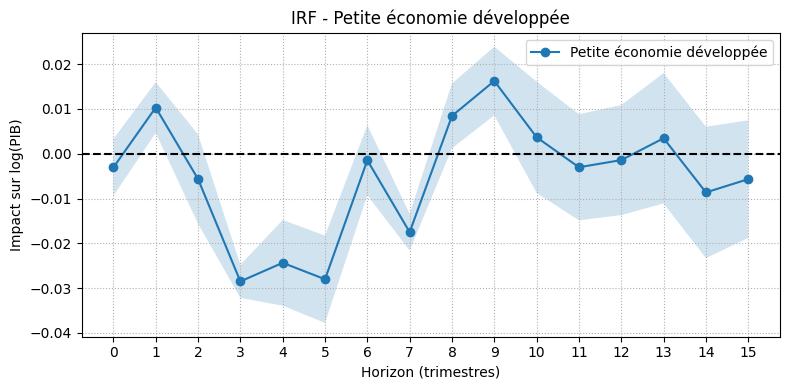

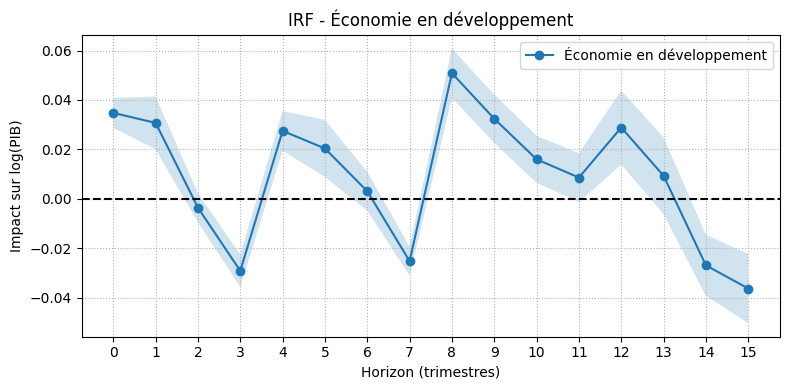

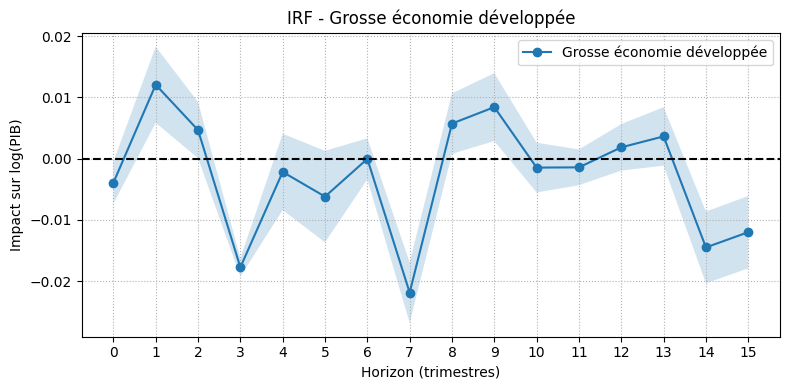

In [217]:
# 1. Chocs mon√©taires US
df_shocks = data_US_clean.reset_index()[["date", "monetary_shocks"]].copy()
df_shocks.columns = ["Time", "shock_US"]
df_shocks["Time"] = pd.PeriodIndex(df_shocks["Time"], freq="Q").to_timestamp()

# 2. Panel principal (data)
data["Time"] = pd.PeriodIndex(data["Time"].astype(str), freq="Q").to_timestamp()

# 3. Fusion
df_merged = pd.merge(data, df_shocks, on="Time", how="inner")

# 4. Filtrer sur le PIB + log
df_pib = df_merged[df_merged["Variable"] == "PIB"].copy()
df_pib = df_pib[df_pib["Value"] > 0]
df_pib["Value"] = np.log(df_pib["Value"])

# 5. Attribution des cat√©gories
def get_category(country):
    for cat, countries in categories.items():
        if country in countries:
            return cat
    return "Autre"

df_pib["Category"] = df_pib["Country"].apply(get_category)

# 6. Projections locales par cat√©gorie
H = 15
results = {}
for cat in df_pib["Category"].unique():
    betas, stderr = [], []
    df_cat = df_pib[df_pib["Category"] == cat].copy()
    df_cat = df_cat.sort_values(["Country", "Time"])
    df_cat = df_cat.set_index(["Country", "Time"])

    for h in range(H + 1):
        df_lp = df_cat.copy()
        df_lp[f"y_lead{h}"] = df_lp.groupby(level="Country")["Value"].shift(-h)
        for lag in range(1, 5):
            df_lp[f"y_lag{lag}"] = df_lp.groupby(level="Country")["Value"].shift(lag)

        df_lp = df_lp.reset_index()
        df_lp["trend"] = df_lp.groupby("Country").cumcount() + 1
        df_lp["trend_sq"] = df_lp["trend"] ** 2
        df_lp = df_lp.set_index(["Country", "Time"])

        needed = [f"y_lead{h}", "shock_US"] + [f"y_lag{k}" for k in range(1, 5)]
        df_model = df_lp.dropna(subset=needed).copy()
        if df_model.empty:
            betas.append(np.nan)
            stderr.append(np.nan)
            continue

        Y = df_model[f"y_lead{h}"]
        X_cols = ["shock_US", "y_lag1", "y_lag2", "y_lag3", "y_lag4", "trend", "trend_sq"]
        df_model["const"] = 1.0
        X = df_model[["const"] + X_cols]

        model = PanelOLS(dependent=Y, exog=X, entity_effects=True)
        res = model.fit(cov_type="clustered", cluster_entity=True)

        betas.append(res.params["shock_US"])
        stderr.append(res.std_errors["shock_US"])

    results[cat] = {
        "beta": np.array(betas),
        "stderr": np.array(stderr)
    }

# 7. Trac√© IRF pour chaque cat√©gorie
horizons = range(H + 1)
for cat, res_cat in results.items():
    beta, se = res_cat["beta"], res_cat["stderr"]
    lower, upper = beta - se, beta + se

    plt.figure(figsize=(8, 4))
    plt.plot(horizons, beta, marker='o', label=cat)
    plt.fill_between(horizons, lower, upper, alpha=0.2)
    plt.axhline(0, color='black', linestyle='--')
    plt.title(f"IRF - {cat}")
    plt.xlabel("Horizon (trimestres)")
    plt.ylabel("Impact sur log(PIB)")
    plt.grid(True, linestyle=':')
    plt.xticks(horizons)
    plt.legend()
    plt.tight_layout()
    plt.show()
    

## Essai du mod√®le en utilisant la croissance du PIB et les premi√®res diff√©rences pour respecter la stationarit√©  <a class="anchor" id="partie5"></a>

### Test de stationarit√© du choc  <a class="anchor" id="partie51"></a>

In [218]:
# test de stationarit√© du choc 
df_test_choc = adfuller(data_US_clean['monetary_shocks'], regression='c', autolag='AIC')
pval = df_test_choc[1]
print("P-value:", pval)


P-value: 4.247563551897223e-07


Le choc est stationnaire donc c'est bon

### Effet du choc sur la croissance du PIB am√©ricain  <a class="anchor" id="partie52"></a>

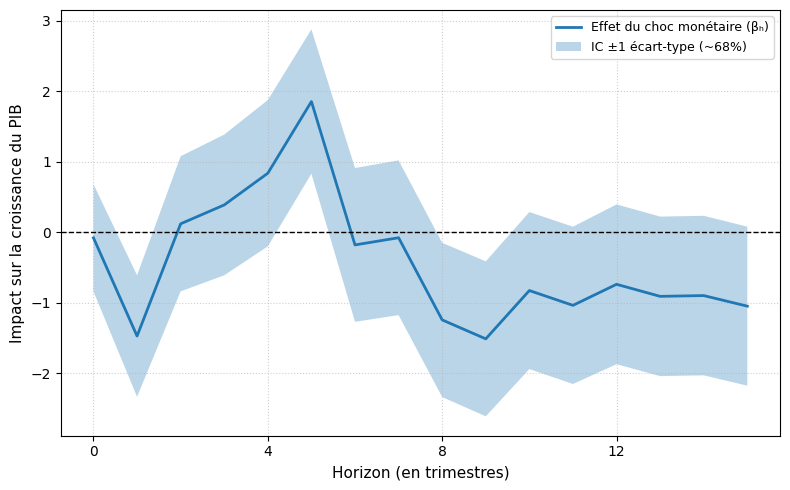

In [270]:
# cr√©er variable de croissance du PIB en glissement annuel
data_US_clean["GDP_growth"] = data_US_clean["GDPC1"].pct_change(periods=4) * 100  # pct_change() donne la variation en pourcentage

H = 15  # nombre d'horizons
betas = []
stderr_list = []

# ==============================
# 2) Boucle sur les horizons h = 0 √† H
# ==============================
for h in range(H + 1):
    # Copie du DataFrame pour chaque horizon (pour √©viter des colonnes temporaires cumul√©es)
    df = data_US_clean.copy()

    # a) Cr√©ation des lags du PIB
    for lag in range(1, 5):
        df[f'GDP_lag{lag}'] = df['GDP_growth'].shift(lag)

    # b) Ajout d'une tendance lin√©aire et quadratique
    df['trend'] = range(len(df))
    df['trend_sq'] = df['trend'] ** 2

    # c) Variable d√©pendante : PIB √† l‚Äôhorizon h (d√©calage de -h)
    df[f'GDP_lead_{h}'] = df['GDP_growth'].shift(-h)

    # d) Nettoyage des lignes NaN (pour √©viter de perdre l'√©quation)
    df_model = df.dropna(subset=[
        f'GDP_lead_{h}',        # la variable d√©pendante (PIB d√©cal√©)
        'monetary_shocks',
        'GDP_lag1', 'GDP_lag2', 'GDP_lag3', 'GDP_lag4'
    ])

    # e) Variable d√©pendante et explicatives
    Y = df_model[f'GDP_lead_{h}']
    X = df_model[['monetary_shocks', 
                  'GDP_lag1', 'GDP_lag2', 'GDP_lag3', 'GDP_lag4',
                  'trend', 'trend_sq']]
    X = sm.add_constant(X)

    # f) Estimation de la r√©gression OLS pour l‚Äôhorizon h
    model = sm.OLS(Y, X).fit()

    # g) Extraction du coefficient du choc et de son √©cart-type
    beta_h = model.params['monetary_shocks']
    stderr_h = model.bse['monetary_shocks']

    # h) Stockage
    betas.append(beta_h)
    stderr_list.append(stderr_h)

# ======================================
# 3) Calcul d'un intervalle de confiance (IC 68%)
#    (Pour 1 √©cart-type, ‚âà 68% si distribution normale)
# ======================================
lower = [b - s for b, s in zip(betas, stderr_list)]
upper = [b + s for b, s in zip(betas, stderr_list)]

# ======================================
# 4) Trac√© de la Fonction de R√©ponse (IRF)
# ======================================
horizons = range(H + 1)

plt.figure(figsize=(8, 5))

# Courbe principale : coefficient Œ≤·µ£
plt.plot(horizons, betas, linewidth=2, label="Effet du choc mon√©taire (Œ≤‚Çï)")

# Intervalle de confiance
plt.fill_between(horizons, lower, upper, alpha=0.3, label="IC ¬±1 √©cart-type (~68%)")

# Ligne horizontale √† 0
plt.axhline(0, color='black', linestyle='--', linewidth=1)

# Mise en forme
plt.xlabel("Horizon (en trimestres)", fontsize=11)
plt.ylabel("Impact sur la croissance du PIB", fontsize=11)
plt.xticks(np.arange(0, H+1, step=4))
plt.grid(True, linestyle=':', alpha=0.6)
plt.legend(loc="best", fontsize=9)
plt.tight_layout()
plt.savefig("reponse US gdp_growth.png", dpi=300)
plt.show()



### effet sur la croissance du PIB des pays europ√©ens  <a class="anchor" id="partie53"></a>


üìã R√©sultats par pays :
        Country                    Category  Coef_monetary_shock   P_value  \
11      Iceland   √âconomie en d√©veloppement             7.443297  0.070907   
5       Estonia   √âconomie en d√©veloppement             2.426397  0.064336   
12      Ireland  Petite √©conomie d√©velopp√©e             1.612492  0.476288   
15    Lithuania   √âconomie en d√©veloppement             1.589271  0.335146   
21      Romania   √âconomie en d√©veloppement             1.490721  0.575913   
25       Sweden  Petite √©conomie d√©velopp√©e             1.251092  0.392550   
2      Bulgaria   √âconomie en d√©veloppement             1.106547  0.480709   
14       Latvia   √âconomie en d√©veloppement             1.032404  0.549616   
22     Slovakia   √âconomie en d√©veloppement             0.936806  0.538915   
1       Belgium  Petite √©conomie d√©velopp√©e             0.586106  0.549494   
4       Denmark  Petite √©conomie d√©velopp√©e             0.580753  0.490743   
16   Luxem

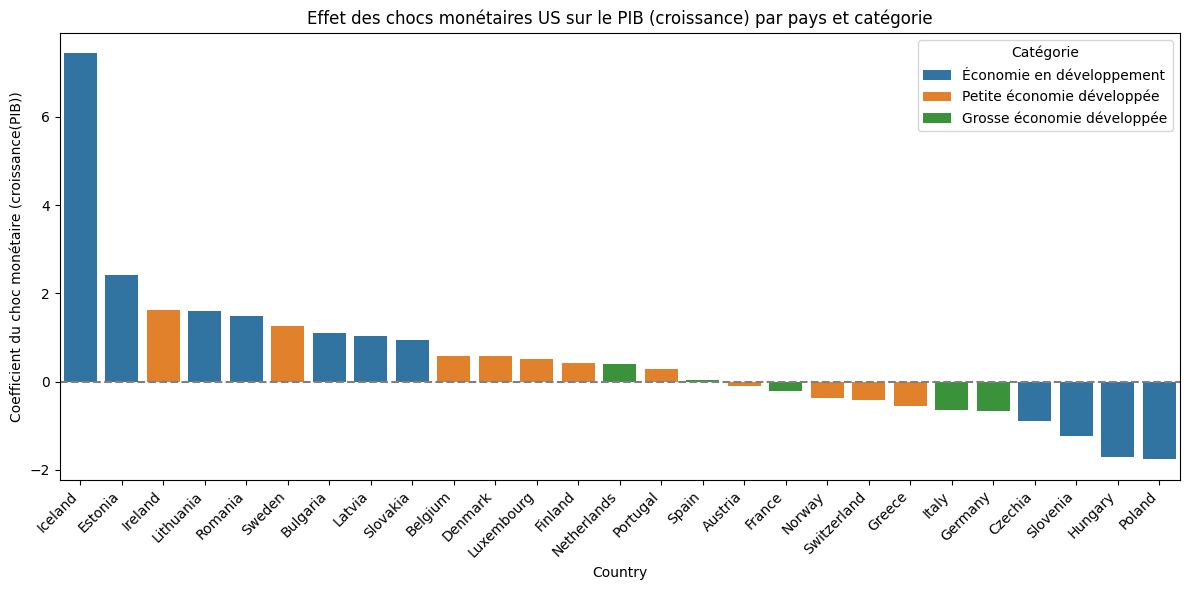

In [272]:


import seaborn as sns
def get_category(country):
    for cat, countries in categories.items():
        if country in countries:
            return cat
    return "Autre"

# --- 2. Filtrer les donn√©es sur le PIB et calculer la croissance en glissement annuel ---
target_variable = "PIB"
df_target = data[data["Variable"] == target_variable].copy()
df_target = df_target.sort_values(["Country", "Time"])

# Croissance en glissement annuel (ex : trimestre t vs trimestre t-4)
df_target["Value"] = df_target.groupby("Country")["Value"].pct_change(periods=4)*100

# Supprimer les lignes avec NaN (caus√©es par le shift)
df_target = df_target.dropna(subset=["Value"])

# --- 3. Trier et ajouter lags + tendances ---
df_target = df_target.sort_values(["Country", "Time"])

for lag in range(1, 5):
    df_target[f"lag{lag}"] = df_target.groupby("Country")["Value"].shift(lag)

df_target["trend"] = df_target.groupby("Country").cumcount() + 1
df_target["trend_sq"] = df_target["trend"] ** 2
df_target["Category"] = df_target["Country"].apply(get_category)

# Il faut merger ces donn√©es avec les chocs mon√©taires obtenus : 
data_US_clean_reset = data_US_clean.reset_index()
monetary_cols = [col for col in data_US_clean_reset.columns if col.startswith("monetary_shocks")]
monetary_df = data_US_clean_reset[["date"] + monetary_cols].copy()
monetary_df = monetary_df.rename(columns={"date": "Time"})
df_target["Time"] = pd.to_datetime(df_target["Time"])
monetary_df["Time"] = pd.to_datetime(monetary_df["Time"])

df_target = df_target.merge(monetary_df, on="Time", how="left")


# --- 4. R√©gressions pays par pays ---
results = []
required_cols = ["Value", "monetary_shocks", "lag1", "lag2", "lag3", "lag4", "trend", "trend_sq"]

for country in df_target["Country"].unique():
    sub = df_target[df_target["Country"] == country].dropna(subset=required_cols)

    if len(sub) < 10:
        continue

    X = sub[["monetary_shocks", "lag1", "lag2", "lag3", "lag4", "trend", "trend_sq"]]
    X = sm.add_constant(X)
    y = sub["Value"]

    model = sm.OLS(y, X).fit()
    coef = model.params["monetary_shocks"]
    pval = model.pvalues["monetary_shocks"]
    category = get_category(country)

    results.append({
        "Country": country,
        "Category": category,
        "Coef_monetary_shock": coef,
        "P_value": pval,
        "R_squared": model.rsquared
    })


# --- 5. R√©sultats ---
results_df = pd.DataFrame(results).sort_values("Coef_monetary_shock", ascending=False)

print("\nüìã R√©sultats par pays :")
print(results_df)
cols_to_export = [col for col in results_df.columns if col != "Category"]
results_df[cols_to_export].to_latex("resultats_pays_1.tex", index=False, float_format="%.4f")

# --- 6. Graphique group√© par cat√©gorie ---
plt.figure(figsize=(12, 6))
sns.barplot(data=results_df, x="Country", y="Coef_monetary_shock", hue="Category", dodge=False)
plt.axhline(0, color="gray", linestyle="--")
plt.title("Effet des chocs mon√©taires US sur le PIB (croissance) par pays et cat√©gorie")
plt.ylabel("Coefficient du choc mon√©taire (croissance(PIB))")
plt.xticks(rotation=45, ha="right")
plt.legend(title="Cat√©gorie")
plt.tight_layout()
plt.savefig("choc_pays_categorie_PIB_croiss.png", dpi=300)
plt.show()
